# Incident Management System

## Problem Statement:

A corp ABC is facing huge loss as finding difficulty handling the incident in time. Using Machine Learning we need to build a model where when we get an incident we are able to predict how long will it take for the incident to be closed with accuracy. Also to be able to predict if we will meet the given SLA or not. 

## Project Outcome:

The aim of the project is to be able to efficiently predict time taken for an incident to be resolved. By doing so we can plan our resources wisely for the incident type, and at the same time imrpove customers experience.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")

# importing data

In [2]:
data=pd.read_csv("incident_event_log.csv")
#data = pd.read_csv('https://drive.google.com/file/d/1caHdL5aeSMoaLyNJaXgy4uCQNTYODIu7/view?usp=sharing')
data.head()

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00


In [3]:
data.columns

Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by',
       'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory',
       'u_symptom', 'cmdb_ci', 'impact', 'urgency', 'priority',
       'assignment_group', 'assigned_to', 'knowledge',
       'u_priority_confirmation', 'notify', 'problem_id', 'rfc', 'vendor',
       'caused_by', 'closed_code', 'resolved_by', 'resolved_at', 'closed_at'],
      dtype='object')

In [4]:
data['u_symptom'].value_counts()

Symptom 491    51985
?              32964
Symptom 534     5559
Symptom 387     2583
Symptom 4       2532
               ...  
Symptom 34         1
Symptom 313        1
Symptom 103        1
Symptom 441        1
Symptom 590        1
Name: u_symptom, Length: 526, dtype: int64

### Understanding Data:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   number                   141712 non-null  object
 1   incident_state           141712 non-null  object
 2   active                   141712 non-null  bool  
 3   reassignment_count       141712 non-null  int64 
 4   reopen_count             141712 non-null  int64 
 5   sys_mod_count            141712 non-null  int64 
 6   made_sla                 141712 non-null  bool  
 7   caller_id                141712 non-null  object
 8   opened_by                141712 non-null  object
 9   opened_at                141712 non-null  object
 10  sys_created_by           141712 non-null  object
 11  sys_created_at           141712 non-null  object
 12  sys_updated_by           141712 non-null  object
 13  sys_updated_at           141712 non-null  object
 14  contact_type        

In [6]:
print(f"Number of rows : {data.shape[0]}")
print(f"Number of columns : {data.shape[1]}")

Number of rows : 141712
Number of columns : 36


In [7]:
#### Duplicate values: 

In [8]:
# checking for any duplicate rows
print(f"Number of duplicate rows: {np.sum([data.duplicated()])}")

Number of duplicate rows: 0


we dont seem to have any duplicate values in the dataset

#### Missing values:

dataset has a lot of `?` we need to replace those with NaN so we can deal with them easily.

In [9]:
# replacing `?` with NaN
data = data.replace('?', np.nan)

In [10]:
# missing values
def get_missing(df):
    """take dataframe as input and return missing count and missing percent of the dataset"""

    missing_df = df.isnull().sum().sort_values(ascending=False).reset_index()
    missing_df = missing_df.rename(columns = {'index': 'column_name', 0:'missing_count'})

    missing_df['missing_percent'] = np.round(missing_df['missing_count']/df.shape[0]*100,2)
    
    return missing_df

In [11]:
# get missing
get_missing(data).set_index('column_name')

,missing_count,missing_percent
column_name,,
caused_by,141689,99.98
vendor,141468,99.83
cmdb_ci,141267,99.69
rfc,140721,99.30
problem_id,139417,98.38
sys_created_at,53076,37.45
sys_created_by,53076,37.45
u_symptom,32964,23.26
assigned_to,27496,19.40


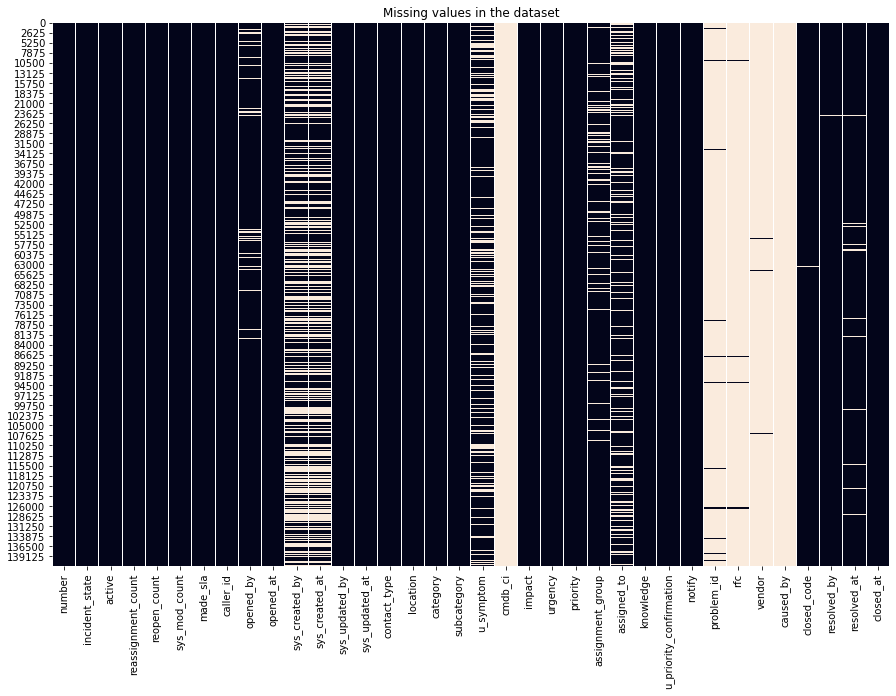

In [12]:
# checking missing data visually
plt.figure(figsize=(15,10))
sns.heatmap(data.isnull(), cbar=False)
plt.title("Missing values in the dataset")
plt.show()

**Inference:**    
    We have columns like `caused_by`, `vendor`, `cmdb_ci`, `rfc`, `problem_id` which have more than 95% of missing dataset. All these columns are actually very important however its possible the values are masked to maintain data security. Also as the columns might be unique as per the clients and their issues they might not be very useful for predicting target. hence removing the columns from the dataset.

#### Null treatment:

In [13]:
# removing columns which have more than 90% missing values
data1 = data.drop(['caused_by','vendor','cmdb_ci','rfc','problem_id'],axis=1)

In [14]:
# checking missing values of the new data1
get_missing(data1)

,column_name,missing_count,missing_percent
0,sys_created_at,53076,37.45
1,sys_created_by,53076,37.45
2,u_symptom,32964,23.26
3,assigned_to,27496,19.40
4,assignment_group,14213,10.03
5,opened_by,4835,3.41
6,resolved_at,3141,2.22
7,closed_code,714,0.50
8,resolved_by,226,0.16
9,subcategory,111,0.08


In [15]:
# imputing categorical columns with mode
for i in ['u_symptom','assigned_to','assignment_group','opened_by','closed_code','resolved_by','subcategory','category','location','caller_id']:
    data1[i]=data1[i].fillna(data1[i].mode()[0])

In [16]:
get_missing(data1)

,column_name,missing_count,missing_percent
0,sys_created_by,53076,37.45
1,sys_created_at,53076,37.45
2,resolved_at,3141,2.22
3,closed_at,0,0.00
4,contact_type,0,0.00
5,incident_state,0,0.00
6,active,0,0.00
7,reassignment_count,0,0.00
8,reopen_count,0,0.00
9,sys_mod_count,0,0.00


## Imputing Date columns having Nan

### Treating missing values in resolved_at column

In [17]:
# Comparing 'number','incident_state','sys_updated_at','resolved_at' to understand about resolved data
data1[['number','incident_state','sys_updated_at','resolved_at']].tail(20)

,number,incident_state,sys_updated_at,resolved_at
141692,INC0120303,Closed,15/2/2017 01:52,NaN
141693,INC0120304,Active,15/2/2017 02:02,17/2/2017 00:47
141694,INC0120304,Resolved,17/2/2017 00:47,17/2/2017 00:47
141695,INC0120304,Closed,17/2/2017 00:50,17/2/2017 00:47
141696,INC0120319,New,15/2/2017 07:09,NaN
141697,INC0120319,Closed,15/2/2017 07:09,NaN
141698,INC0120495,New,15/2/2017 11:58,NaN
141699,INC0120495,Active,15/2/2017 14:15,NaN
141700,INC0120495,Active,15/2/2017 14:53,NaN
141701,INC0120495,Active,15/2/2017 16:44,NaN


We can clearly see that, resolved_at column is nothing but sys_updated_at information of every individual incident where the incident_state is 'Resolved' at max.

So, We try to impute the resolved_at columns having Nan, with respective sys_updated_at information for every new_incidents where the incident state is 'resolved'.

In [18]:
ins=data1['number'].unique()
dt=data1[data1['incident_state']=='Resolved'].groupby(by='number',as_index=False,axis=0)['sys_updated_at'].max()
print('unique incidents which got resolved and their respective datetime : \n',dt)
print('*'*100)
print('Unique Incidents : \n',ins)
print('*'*100)
print('number of unique incidents :',data1['number'].nunique())
print('*'*100)
print('number of unique incidents wich is having resolved info : \n',dt.nunique())
print('*'*100)


unique incidents which got resolved and their respective datetime : 
            number   sys_updated_at
0      INC0000045  29/2/2016 11:29
1      INC0000047   1/3/2016 09:52
2      INC0000057   1/3/2016 02:55
3      INC0000060   2/3/2016 12:06
4      INC0000062  29/2/2016 15:51
...           ...              ...
24900  INC0118999  10/2/2017 16:35
24901  INC0119390  14/2/2017 09:37
24902  INC0120304  17/2/2017 00:47
24903  INC0120835  16/2/2017 09:53
24904  INC0121064  16/2/2017 16:38

[24905 rows x 2 columns]
****************************************************************************************************
Unique Incidents : 
 ['INC0000045' 'INC0000047' 'INC0000057' ... 'INC0120495' 'INC0120835'
 'INC0121064']
****************************************************************************************************
number of unique incidents : 24918
****************************************************************************************************
number of unique incidents wich is havin

There are some incidents which don't have resolved information we can drop those rows.

In [19]:
# Finding incidents that not resolved.
a=data1['number'].unique().tolist()
b=dt['number'].tolist()
d=[]
for i in a:
    if i not in b:
        d.append(i)

print('incidents that not resolved :',d)
print('number of incidents not resolved : ',len(d))

incidents that not resolved : ['INC0003115', 'INC0005100', 'INC0020014', 'INC0119241', 'INC0119289', 'INC0119392', 'INC0119457', 'INC0119983', 'INC0119987', 'INC0120268', 'INC0120303', 'INC0120319', 'INC0120495']
number of incidents not resolved :  13


In [20]:
# finding number of rows associated these incidents
c=0
for i in d:
  c+=(data1['number']==i).sum()
print(c)

34


In [21]:
# Droping the columns that don't resolved
for i in d:
    ind = data1[data1['number']==i].index
    data1=data1.drop(index=ind)
print('Number unique incidents after drop : ',data1['number'].nunique())    

Number unique incidents after drop :  24905


In [22]:
data1.reset_index(drop=True,inplace=True)

In [23]:
#Unique incidents that is having Nan at resolved_at
inst=data1[data1['resolved_at'].isnull()]['number'].unique()
print('Unique incidents that is having Nan at resolved_at :\n',inst)
print('*'*100)
print('Number of incidents that is having Nan at resolved_at :',len(inst))
print('*'*100)

Unique incidents that is having Nan at resolved_at :
 ['INC0000093' 'INC0000160' 'INC0000199' ... 'INC0034224' 'INC0034421'
 'INC0034431']
****************************************************************************************************
Number of incidents that is having Nan at resolved_at : 1543
****************************************************************************************************


In [24]:
# imputing resolved at columns with respective sys_updated_at
for i in inst:
    temp=data1[data1['number']==i]
    a=dt[dt['number']==i]
    a=a['sys_updated_at'].iloc[-1]
    li = temp.index.tolist()
    for j in li:
        data1['resolved_at'].iloc[j]=a 

In [25]:
#checking missing values after imputing resolved at column
data1.isnull().sum()

number                         0
incident_state                 0
active                         0
reassignment_count             0
reopen_count                   0
sys_mod_count                  0
made_sla                       0
caller_id                      0
opened_by                      0
opened_at                      0
sys_created_by             53050
sys_created_at             53050
sys_updated_by                 0
sys_updated_at                 0
contact_type                   0
location                       0
category                       0
subcategory                    0
u_symptom                      0
impact                         0
urgency                        0
priority                       0
assignment_group               0
assigned_to                    0
knowledge                      0
u_priority_confirmation        0
notify                         0
closed_code                    0
resolved_by                    0
resolved_at                    0
closed_at 

### Treating missing values in Sys_created_at column

In [26]:
# Comparing 'number','incident_state','sys_updated_at','sys_created_at' to understand about resolved data
data1[['number','incident_state','sys_updated_at','sys_created_at']].head(20)

,number,incident_state,sys_updated_at,sys_created_at
0,INC0000045,New,29/2/2016 01:23,29/2/2016 01:23
1,INC0000045,Resolved,29/2/2016 08:53,29/2/2016 01:23
2,INC0000045,Resolved,29/2/2016 11:29,29/2/2016 01:23
3,INC0000045,Closed,5/3/2016 12:00,29/2/2016 01:23
4,INC0000047,New,29/2/2016 04:57,29/2/2016 04:57
5,INC0000047,Active,29/2/2016 05:30,29/2/2016 04:57
6,INC0000047,Active,29/2/2016 05:33,29/2/2016 04:57
7,INC0000047,Active,29/2/2016 11:31,29/2/2016 04:57
8,INC0000047,Active,29/2/2016 11:32,29/2/2016 04:57
9,INC0000047,Active,1/3/2016 09:14,29/2/2016 04:57


We can clearly see that, sys_created_at column is nothing but sys_updated_at information of every individual incident where the incident_state is 'New' at min.

So, We try to impute the Sys_created_at columns having Nan, with respective sys_updated_at information for every new_incidents where the incident state is 'New'.

In [27]:
ins=data1['number'].unique()
dt1=data1[data1['incident_state']=='New'].groupby(by='number',as_index=False,axis=0)['sys_updated_at'].min()
print('unique incidents which is new and their respective datetime : \n',dt1)
print('*'*100)
print('Unique Incidents : \n',ins)
print('*'*100)
print('number of unique incidents :',data1['number'].nunique())
print('*'*100)
print('number of unique incidents wich is having new info : \n',dt1.nunique())
print('*'*100)

unique incidents which is new and their respective datetime : 
            number   sys_updated_at
0      INC0000045  29/2/2016 01:23
1      INC0000047  29/2/2016 04:57
2      INC0000057   1/3/2016 02:53
3      INC0000060  29/2/2016 06:42
4      INC0000062  29/2/2016 07:26
...           ...              ...
16379  INC0118593  10/2/2017 02:10
16380  INC0118633   9/2/2017 18:39
16381  INC0118678  10/2/2017 02:15
16382  INC0118690  10/2/2017 06:43
16383  INC0119390  13/2/2017 10:33

[16384 rows x 2 columns]
****************************************************************************************************
Unique Incidents : 
 ['INC0000045' 'INC0000047' 'INC0000057' ... 'INC0120304' 'INC0120835'
 'INC0121064']
****************************************************************************************************
number of unique incidents : 24905
****************************************************************************************************
number of unique incidents wich is having new 

In [28]:
# Finding incidents that not having new information in incident_state.
a=data1['number'].unique().tolist()
b=dt1['number'].tolist()
c=[]
for i in a:
    if i not in b:
        c.append(i)
print('number of incidents dont have new : ',len(c))

number of incidents dont have new :  8521


In [29]:
#Unique incidents that is having Nan at resolved_at
inst=data1[data1['resolved_at'].isnull()]['number'].unique()


In [32]:
#Selecting incidents that having Nan at sys_crated_at and having information of Sys_updatated_at with incident_state as 'New'
ins=[]
for i in dt1['number']:
    if data1[data1['number']==i]['sys_created_at'].isnull().any():
        ins.append(i)


print('Number of incidents that is having Nan at sys_created_at :',len(ins))
print('*'*100)

Number of incidents that is having Nan at sys_created_at : 6439
****************************************************************************************************


In [186]:
# imputing sys_created_at columns with respective sys_updated_at
for i in ins:
    temp=data1[data1['number']==i]
    a=dt1[dt1['number']==i]
    a=a['sys_updated_at'].iloc[-1]
    li = temp.index.tolist()
    for j in li:
        data1['sys_created_at'].iloc[j]=a 

In [187]:
#checking missing values after imputing sys_created_at column
data1.isnull().sum()

number                         0
incident_state                 0
active                         0
reassignment_count             0
reopen_count                   0
sys_mod_count                  0
made_sla                       0
caller_id                      0
opened_by                      0
opened_at                      0
sys_created_by             53050
sys_created_at             16791
sys_updated_by                 0
sys_updated_at                 0
contact_type                   0
location                       0
category                       0
subcategory                    0
u_symptom                      0
impact                         0
urgency                        0
priority                       0
assignment_group               0
assigned_to                    0
knowledge                      0
u_priority_confirmation        0
notify                         0
closed_code                    0
resolved_by                    0
resolved_at                    0
closed_at 

###### for the remaining portion of sys_created_at : 
sys_created_at is almost close to opened_at column replacing values where sys_created_at == null with 'opened_at'

In [188]:
data1.loc[data1.sys_created_at.isnull(),'sys_created_at'] = data1.loc[data1.sys_created_at.isnull(),'opened_at']

In [189]:
# there is no way to predict the values for `sys_created_by` but we can probably use forward filling method for now as we dont want to miss out on any information
data1['sys_created_by'].fillna(method='ffill', inplace=True)

In [190]:
#checking missing values after imputing sys_created_at,and sys_created_by column
data1.isnull().sum()

number                     0
incident_state             0
active                     0
reassignment_count         0
reopen_count               0
sys_mod_count              0
made_sla                   0
caller_id                  0
opened_by                  0
opened_at                  0
sys_created_by             0
sys_created_at             0
sys_updated_by             0
sys_updated_at             0
contact_type               0
location                   0
category                   0
subcategory                0
u_symptom                  0
impact                     0
urgency                    0
priority                   0
assignment_group           0
assigned_to                0
knowledge                  0
u_priority_confirmation    0
notify                     0
closed_code                0
resolved_by                0
resolved_at                0
closed_at                  0
dtype: int64

Inference: we have dealt with missing values by doing the required imputation, and there seem to be no missing values any more in any of the columns.

#### Understanding data types:

In [191]:
print(f"Data shape after null treatment : {data1.shape}")

print("Columns and their datatypes:")
data1.dtypes

Data shape after null treatment : (141678, 31)
Columns and their datatypes:


number                     object
incident_state             object
active                       bool
reassignment_count          int64
reopen_count                int64
sys_mod_count               int64
made_sla                     bool
caller_id                  object
opened_by                  object
opened_at                  object
sys_created_by             object
sys_created_at             object
sys_updated_by             object
sys_updated_at             object
contact_type               object
location                   object
category                   object
subcategory                object
u_symptom                  object
impact                     object
urgency                    object
priority                   object
assignment_group           object
assigned_to                object
knowledge                    bool
u_priority_confirmation      bool
notify                     object
closed_code                object
resolved_by                object
resolved_at   

**Inference:**
    We can see that date columns like `sys_created_at`, `opened_at`, `sys_updated_at`, `resolved_at` and `closed_at` are also listed as 'Object' datatype which is not accurate.

## Data Preprocessing: 

#### Handling date columns

In [192]:
# here we see a lot of columns which are actually dates but not categories
dates = ['sys_created_at', 'opened_at', 'resolved_at', 'closed_at', 'sys_updated_at']

# updating datatype of the date columns

for feat in dates:
    data1[feat] = pd.to_datetime(data1[feat], format='%d/%m/%Y %H:%M')

In [193]:
# rechecking the datatypes
data1.dtypes

number                             object
incident_state                     object
active                               bool
reassignment_count                  int64
reopen_count                        int64
sys_mod_count                       int64
made_sla                             bool
caller_id                          object
opened_by                          object
opened_at                  datetime64[ns]
sys_created_by                     object
sys_created_at             datetime64[ns]
sys_updated_by                     object
sys_updated_at             datetime64[ns]
contact_type                       object
location                           object
category                           object
subcategory                        object
u_symptom                          object
impact                             object
urgency                            object
priority                           object
assignment_group                   object
assigned_to                       

### columns Data types, number of columns in each datatype

In [194]:
# lets get our numerical , categorical and datetime features separately
feat_num = data1.select_dtypes(np.number).columns.tolist()
print(f"Numerical columns : {len(feat_num)}\n{feat_num}\n")

# categorical and boolean features
feat_cat = data1.select_dtypes(['object', 'bool']).columns.tolist()
print(f"Categorical columns : {len(feat_cat)}\n{feat_cat}\n")      

# dates features
feat_dates = data1.select_dtypes(['datetime']).columns.tolist()
print(f"Datetime columns : {len(feat_dates)}\n{feat_dates}\n")      

Numerical columns : 3
['reassignment_count', 'reopen_count', 'sys_mod_count']

Categorical columns : 23
['number', 'incident_state', 'active', 'made_sla', 'caller_id', 'opened_by', 'sys_created_by', 'sys_updated_by', 'contact_type', 'location', 'category', 'subcategory', 'u_symptom', 'impact', 'urgency', 'priority', 'assignment_group', 'assigned_to', 'knowledge', 'u_priority_confirmation', 'notify', 'closed_code', 'resolved_by']

Datetime columns : 5
['opened_at', 'sys_created_at', 'sys_updated_at', 'resolved_at', 'closed_at']



In [195]:
# checking basic statistics of numerical features
data1[feat_num].describe()

,reassignment_count,reopen_count,sys_mod_count
count,141678.000000,141678.000000,141678.000000
mean,1.104434,0.021923,5.081869
std,1.734807,0.207327,7.681309
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,1.000000,0.000000,3.000000
75%,1.000000,0.000000,6.000000
max,27.000000,8.000000,129.000000


## Outliers:

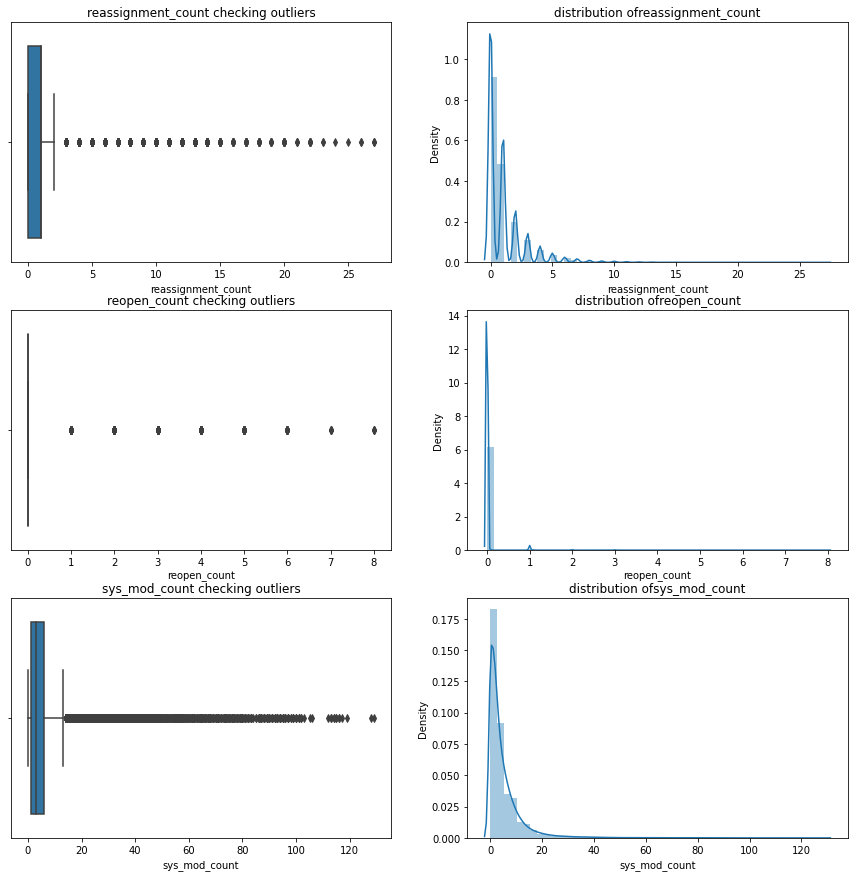

In [196]:
fig, ax = plt.subplots(3,2, figsize=(15,15))

feat_ind = 0
for r in range(3):
    ax[r,0].set_title(feat_num[feat_ind]+' checking outliers')
    sns.boxplot(data1[feat_num[feat_ind]], ax = ax[r,0])
    
    ax[r,1].set_title('distribution of'+feat_num[feat_ind])
    sns.distplot(data1[feat_num[feat_ind]], ax =ax[r,1])
    
    feat_ind+=1

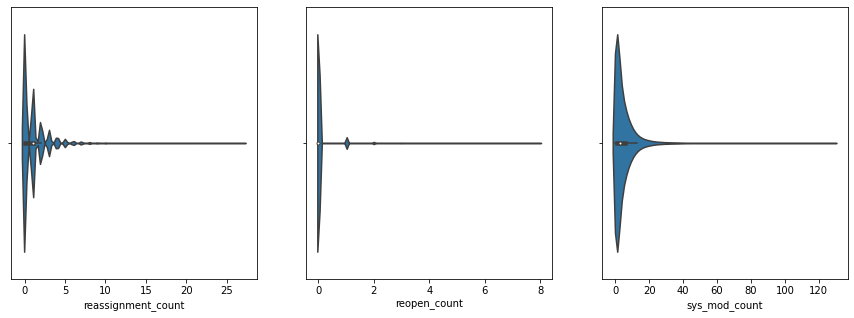

In [197]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

feat_ind=0
for c in range(3):
    sns.violinplot(data1[feat_num[feat_ind]], ax=ax[c])
    feat_ind+=1

**Inference:**
    We can see from the plots that 
    - `reassignment_count` : we have values from 0-27 however majority values are between 0-3 and rest seem to be at much lesser count i.e outliers.
    - `reopen_count` : we have values ranging from 0-8 however majority values are of 0 however we have very few values ranging from 2-8.
    - `sys_mod_count` : we have values ranging from 0-129 where majority values are between 0-6 and we have very less frequency for sys_mod_count > 20. 

In [198]:
#checking outliers

def check_outliers(x):
    
    q1 = np.quantile(x, 0.25)
    q3 = np.quantile(x,0.75)
    iqr = q3-q1 
    
    more_than_upperbound = np.sum(x>(q3+1.5*iqr))
    less_than_lowerbound = np.sum(x<(q1-1.5*iqr))
    
#     print(np.sum(x>(q3+1.5*iqr)))
    
    return [less_than_lowerbound, more_than_upperbound]



In [199]:

less_than_lowerbound = [check_outliers(data1[feat])[0] for feat in feat_num]
more_than_upperbound = [check_outliers(data1[feat])[1] for feat in feat_num]

df_outliers = pd.DataFrame({'columns': feat_num,
                  'less_than_lowerbound': less_than_lowerbound,
                  'more_than_upperbound': more_than_upperbound})

df_outliers['outlier_percent']= df_outliers['more_than_upperbound']/data.shape[0]
df_outliers


,columns,less_than_lowerbound,more_than_upperbound,outlier_percent
0,reassignment_count,0,19635,0.138556
1,reopen_count,0,2314,0.016329
2,sys_mod_count,0,10900,0.076917


**Inference:**
    If check outlier percent `reassignment_count`  has almost 13.8% outliers and `sys_mod_count` has almost 8% of data as outliers and capping them will affect the information, hence not capping the data.

### Transformation:

**Inference:** We are instead using transformation on `reassignment_count` and `sys_mod_count` to slightly normalize the data and leaving reopen_count as it is.

In [200]:
data1['reassignment_count'] = np.power(data1['reassignment_count'], 1/2)

data1['sys_mod_count'] = np.power(data1['sys_mod_count'], 1/2)


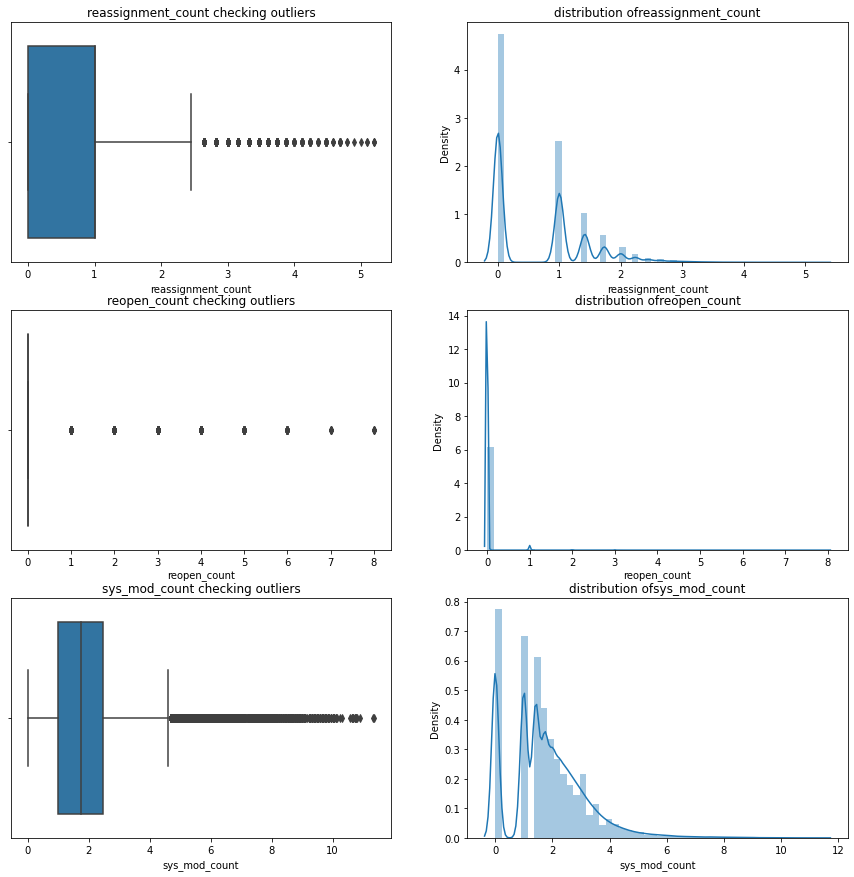

In [201]:
fig, ax = plt.subplots(3,2, figsize=(15,15))

feat_ind = 0
for r in range(3):
    ax[r,0].set_title(feat_num[feat_ind]+' checking outliers')
    sns.boxplot(data1[feat_num[feat_ind]], ax = ax[r,0])
    
    ax[r,1].set_title('distribution of'+feat_num[feat_ind])
    sns.distplot(data1[feat_num[feat_ind]], ax =ax[r,1])
    
    feat_ind+=1

In [202]:

less_than_lowerbound = [check_outliers(data1[feat])[0] for feat in feat_num]
more_than_upperbound = [check_outliers(data1[feat])[1] for feat in feat_num]

df_outliers = pd.DataFrame({'columns': feat_num,
                  'less_than_lowerbound': less_than_lowerbound,
                  'more_than_upperbound': more_than_upperbound})

df_outliers['outlier_percent']= df_outliers['more_than_upperbound']/data.shape[0]
df_outliers


,columns,less_than_lowerbound,more_than_upperbound,outlier_percent
0,reassignment_count,0,2705,0.019088
1,reopen_count,0,2314,0.016329
2,sys_mod_count,0,4449,0.031395


## Feature Engineering:

In [203]:
# creating predicted_closed_days column to predict sla timeline
data1['predicted_closed_days']=(data1.closed_at- data1.opened_at).dt.total_seconds()/ (24 * 60 * 60)
data1['predicted_closed_days'].describe()

count    141678.000000
mean         17.066108
std          27.158426
min           0.001389
25%           5.213889
50%           9.375694
75%          17.406944
max         341.275694
Name: predicted_closed_days, dtype: float64

In [204]:
# creating days_took_to_sys_created column to predict time taken by sysytem ti create
data1['days_took_to_sys_created']=(data1.sys_created_at- data1.opened_at).dt.total_seconds()/ (24 * 60 * 60)
data1['days_took_to_sys_created'].describe()

count    141678.000000
mean          0.103337
std           1.254858
min          -0.102083
25%           0.000000
50%           0.002083
75%           0.005556
max         102.025694
Name: days_took_to_sys_created, dtype: float64

In [205]:
# creating days_took_to_sys_updated column to predict time taken by sysytem to update
data1['days_took_to_sys_updated']=(data1.sys_updated_at- data1.sys_created_at).dt.total_seconds()/ (24 * 60 * 60)
data1['days_took_to_sys_updated'].describe()

count    141678.000000
mean          6.419451
std          18.093484
min        -102.025694
25%           0.004861
50%           0.978472
75%           5.931250
max         341.274306
Name: days_took_to_sys_updated, dtype: float64

In [206]:
# separating opened_at column for days, month, time
data1['opened_month']=data1.opened_at.dt.month
data1['opened_day'] = data1.opened_at.dt.day
data1['opened_hour'] = data1.opened_at.dt.hour
data1['opened_minute'] = data1.opened_at.dt.minute

In [207]:
# separating sys_updated_at column for days, month, time
data1['sys_updated_month']=data1.sys_updated_at.dt.month
data1['sys_updated_day'] = data1.sys_updated_at.dt.day
data1['sys_updated_hour'] = data1.sys_updated_at.dt.hour
data1['sys_updated_minute'] = data1.sys_updated_at.dt.minute

In [208]:
# separating sys_created_at column for days, month, time
data1['sys_created_month']=data1.sys_created_at.dt.month
data1['sys_created_day'] = data1.sys_created_at.dt.day
data1['sys_created_hour'] = data1.sys_created_at.dt.hour
data1['sys_created_minute'] = data1.sys_created_at.dt.minute

In [209]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141678 entries, 0 to 141677
Data columns (total 46 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   number                    141678 non-null  object        
 1   incident_state            141678 non-null  object        
 2   active                    141678 non-null  bool          
 3   reassignment_count        141678 non-null  float64       
 4   reopen_count              141678 non-null  int64         
 5   sys_mod_count             141678 non-null  float64       
 6   made_sla                  141678 non-null  bool          
 7   caller_id                 141678 non-null  object        
 8   opened_by                 141678 non-null  object        
 9   opened_at                 141678 non-null  datetime64[ns]
 10  sys_created_by            141678 non-null  object        
 11  sys_created_at            141678 non-null  datetime64[ns]
 12  sy

## Univariate Analysis:

In [210]:
data1[feat_dates].describe()

,opened_at,sys_created_at,sys_updated_at,resolved_at,closed_at
count,141678,141678,141678,141678,141678
unique,19838,19559,50649,19488,2694
top,2016-04-14 20:42:00,2016-03-07 09:11:00,2016-03-24 18:40:00,2016-06-03 16:29:00,2016-03-24 18:59:00
freq,58,64,420,96,3324
first,2016-02-29 01:16:00,2016-02-29 01:23:00,2016-02-29 01:23:00,2016-02-29 08:56:00,2016-02-29 17:47:00
last,2017-02-16 14:17:00,2017-02-16 14:17:00,2017-02-18 15:00:00,2017-02-17 00:47:00,2017-02-18 15:00:00


In [211]:
# opened_at distribution
df = data.copy()
df[['opened_at_date', 'opened_at_date_time']] = df['opened_at'].str.split(expand = True)

df.head()

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,cmdb_ci,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at,opened_at_date,opened_at_date_time
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 21,29/2/2016 01:23,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 56,NaN,True,False,Do Not Notify,NaN,NaN,NaN,NaN,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00,29/2/2016,01:16
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 642,29/2/2016 08:53,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 56,NaN,True,False,Do Not Notify,NaN,NaN,NaN,NaN,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00,29/2/2016,01:16
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 804,29/2/2016 11:29,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 56,NaN,True,False,Do Not Notify,NaN,NaN,NaN,NaN,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00,29/2/2016,01:16
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,Created by 6,29/2/2016 01:23,Updated by 908,5/3/2016 12:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 56,NaN,True,False,Do Not Notify,NaN,NaN,NaN,NaN,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00,29/2/2016,01:16
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,Created by 171,29/2/2016 04:57,Updated by 746,29/2/2016 04:57,Phone,Location 165,Category 40,Subcategory 215,Symptom 471,NaN,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 89,True,False,Do Not Notify,NaN,NaN,NaN,NaN,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00,29/2/2016,04:40


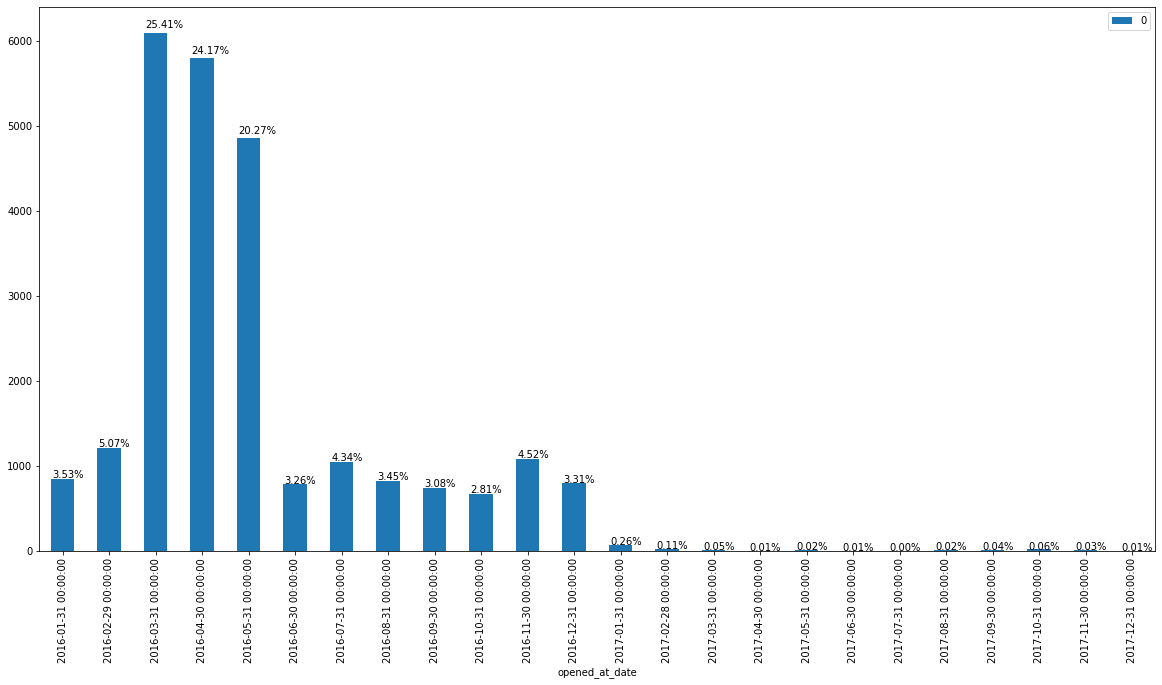

In [212]:
# df.head()
df['opened_at_date'] = pd.to_datetime(df.opened_at_date)
incidents_open_per_day = df.groupby(['number', 'opened_at_date']).size().reset_index().groupby('opened_at_date')[[0]].count()
incidents_open_per_month = incidents_open_per_day.groupby(pd.Grouper(freq="M")).sum()

ipm=incidents_open_per_month.plot(kind = 'bar', figsize =(20,10))
df[['closed_at_date', 'closed_at_date_time']] = df['closed_at'].str.split(expand = True)
df.head()
df['closed_at_date'] = pd.to_datetime(df.opened_at_date)
total = len('incidents_open_per_month')
for i in ipm.patches:
        percentage = '{:.2f}%'.format(0.1* i.get_height()/total)
        x = i.get_x() + i.get_width()/20
        y = i.get_y() + i.get_height()*1.01
        ipm.annotate(percentage, (x, y))

plt.show()



**Inference:**
    Checking  distribution of opened dates we can see we have more number of incidents for 1st of the year and maximum number of cases for months March-May

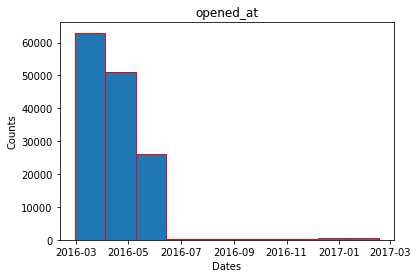

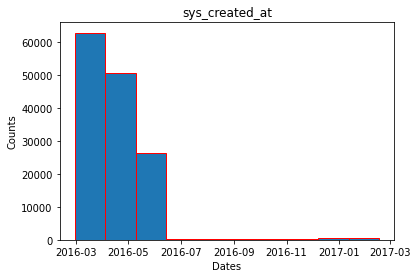

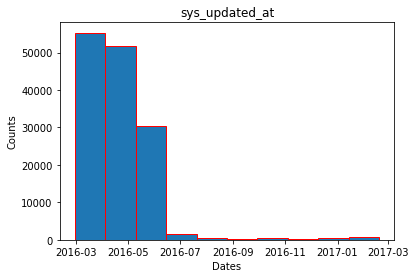

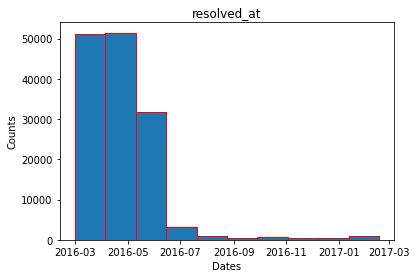

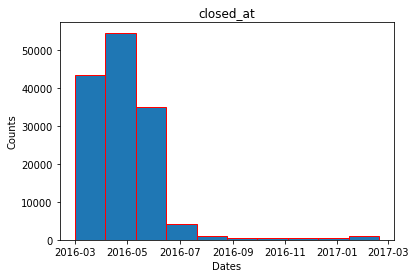

In [213]:
for feat in feat_dates:
    plt.title(feat)
    plt.hist(data1[feat],edgecolor='red')
    plt.xlabel("Dates")
    plt.ylabel("Counts")
    plt.show()
    

**Inference:**
    - `opened_at` : has values starting from 29/02/2016 1:16am to 16/02/2017 2.15am, however majority data is for dates between 03-2016 to 06/2016.
    - `sys_created_at` : has values starting in similar range as opened_at only there seems to be few minutes difference but distribution is almost same
    - `sys_updated_at` : has values starting from 29/02/2016 1:23am to 16/02/2017 3am also majority updates happened in 04/2016
    - `resolved_at` : has values starting from 29/02/2016 9:04am to 16/02/2017 12:47pm also majority cases were resolved in 06/2016
    - `closed_at` : has values starting from 29/02/2016 5:47pm to 18/02/2017 3pm also majority cases seem to be closed in 03/2016.
            

*Note: There is a significant difference between resolved and closed time. sometimes also day this could be because the ticket might seem to be resolved by the technician however problem might actually not been solved.*
    - 

#### Checking categorical features:

In [214]:
# checking categories and their value_counts
for feat in feat_cat:
    print(f"Number of unique categories in {feat} is {data1[feat].nunique()}")

Number of unique categories in number is 24905
Number of unique categories in incident_state is 9
Number of unique categories in active is 2
Number of unique categories in made_sla is 2
Number of unique categories in caller_id is 5242
Number of unique categories in opened_by is 206
Number of unique categories in sys_created_by is 185
Number of unique categories in sys_updated_by is 845
Number of unique categories in contact_type is 4
Number of unique categories in location is 223
Number of unique categories in category is 57
Number of unique categories in subcategory is 254
Number of unique categories in u_symptom is 525
Number of unique categories in impact is 3
Number of unique categories in urgency is 3
Number of unique categories in priority is 4
Number of unique categories in assignment_group is 78
Number of unique categories in assigned_to is 234
Number of unique categories in knowledge is 2
Number of unique categories in u_priority_confirmation is 2
Number of unique categories i

In [215]:
# counting unique values per categorical column
data1[feat_cat].nunique().sort_values(ascending=False)

number                     24905
caller_id                   5242
sys_updated_by               845
u_symptom                    525
subcategory                  254
assigned_to                  234
location                     223
resolved_by                  216
opened_by                    206
sys_created_by               185
assignment_group              78
category                      57
closed_code                   17
incident_state                 9
priority                       4
contact_type                   4
urgency                        3
impact                         3
knowledge                      2
u_priority_confirmation        2
notify                         2
made_sla                       2
active                         2
dtype: int64

**Inference:**
    We can see we have few categories which are just too many like number, caller_id, and most of them having more than 100 categories.
    `number` seems like a redundant column and has a lot of unique values, however we can see these are unique incident_numbers and few incidents are more than 1

In [217]:
### Distribution of categories:

In [218]:
feat_category = data1[feat_cat].nunique()[data1[feat_cat].nunique()<=100].index.tolist()
feat_others = data1[feat_cat].nunique()[data1[feat_cat].nunique()>100].index.tolist()

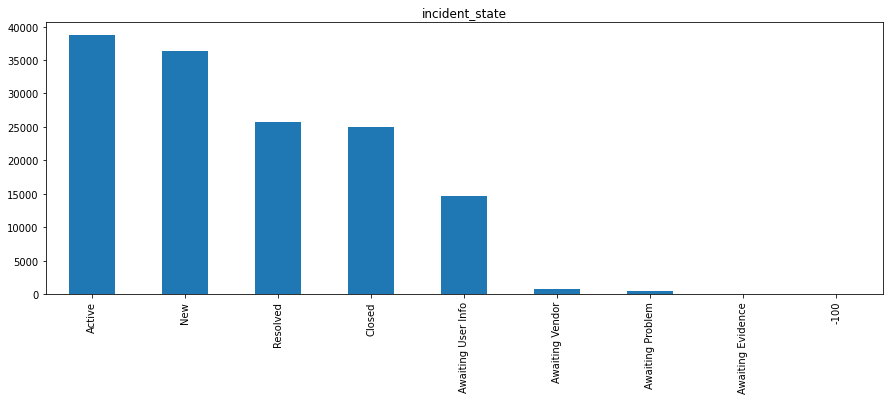

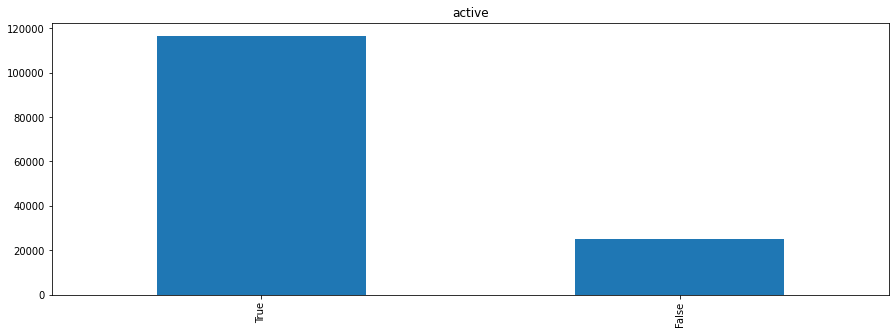

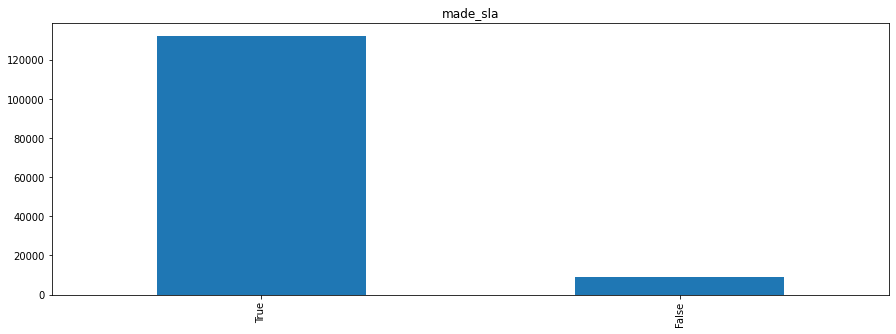

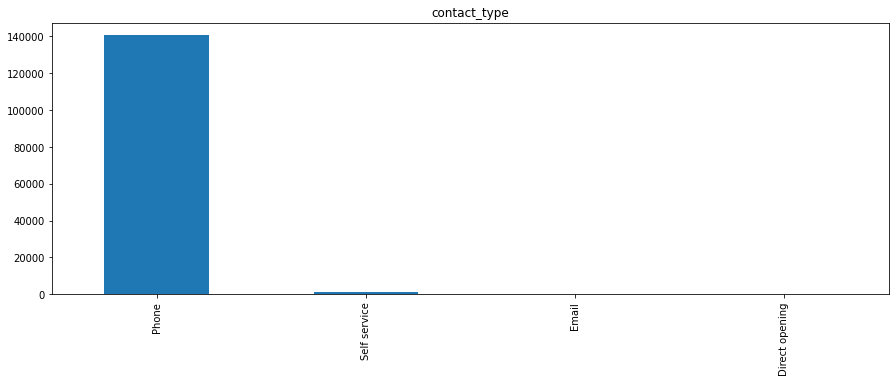

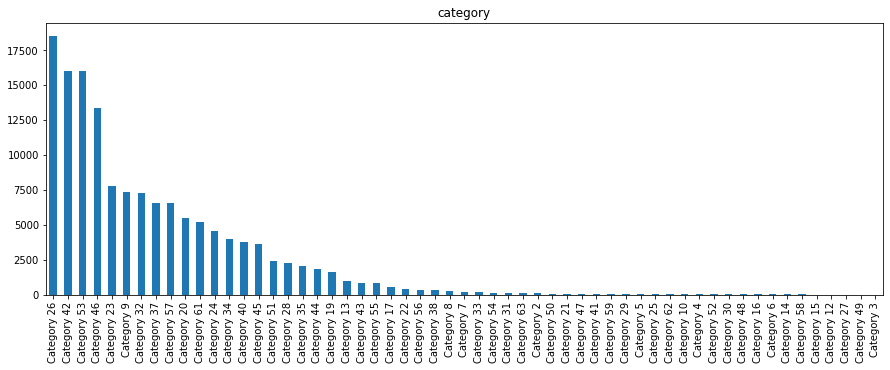

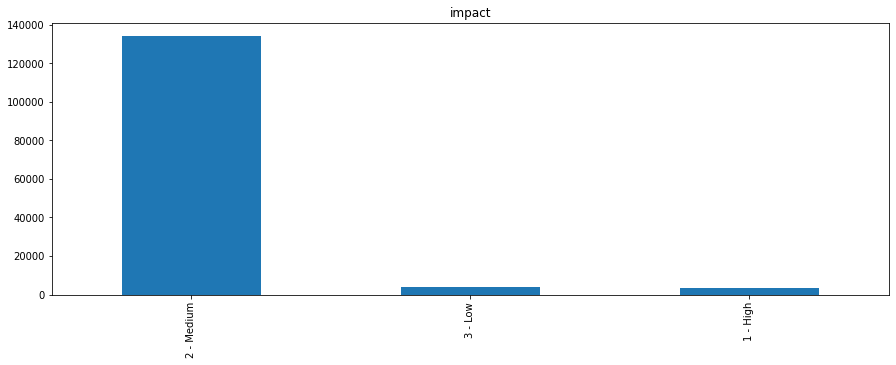

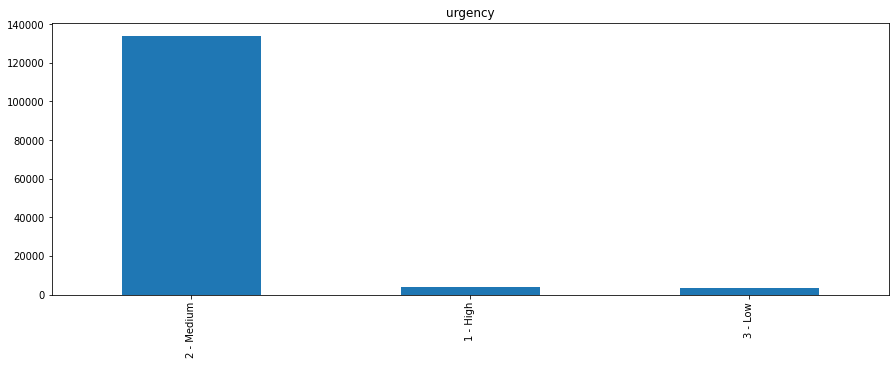

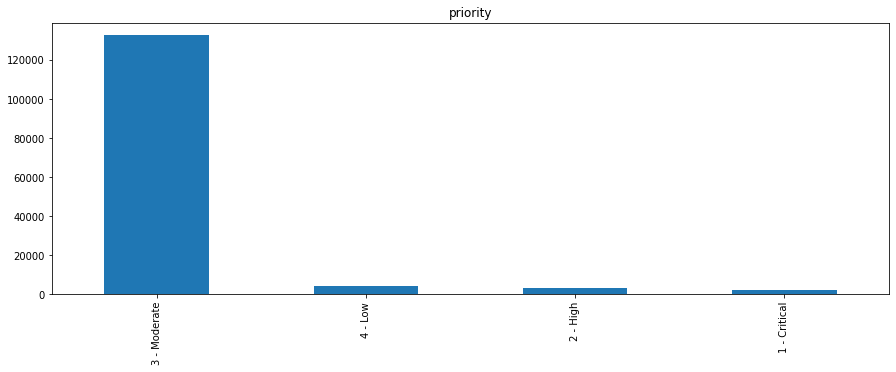

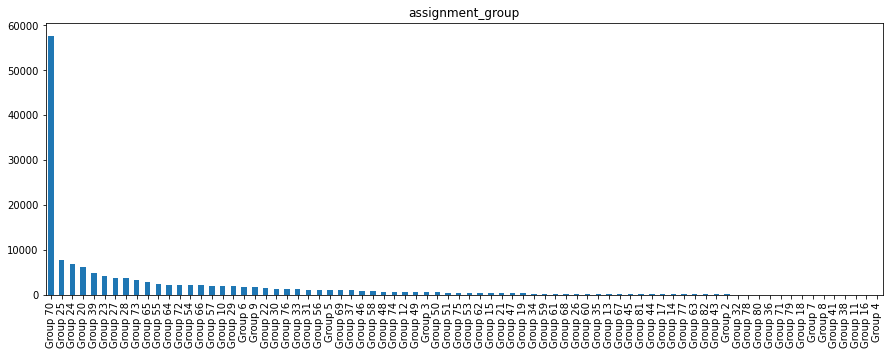

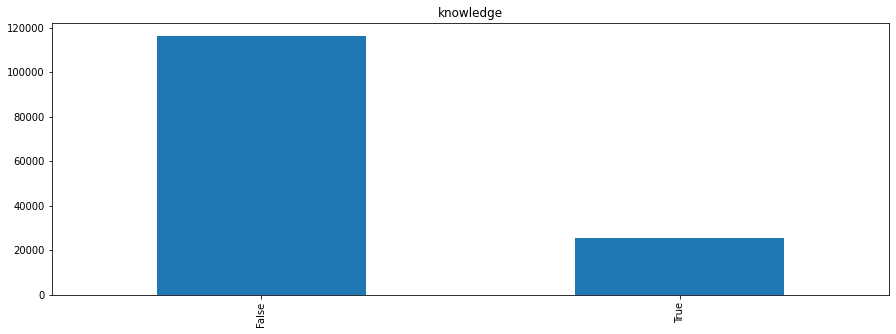

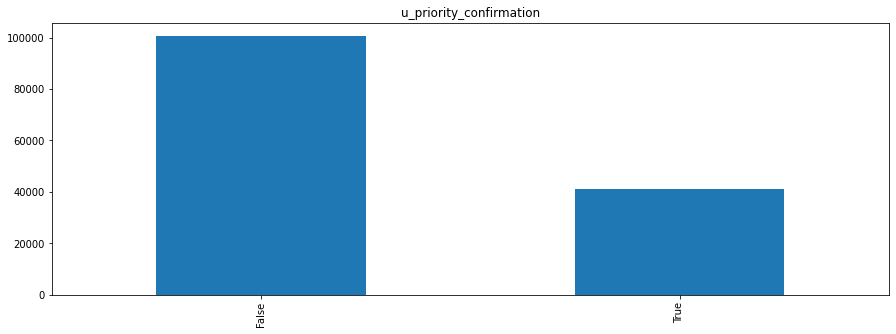

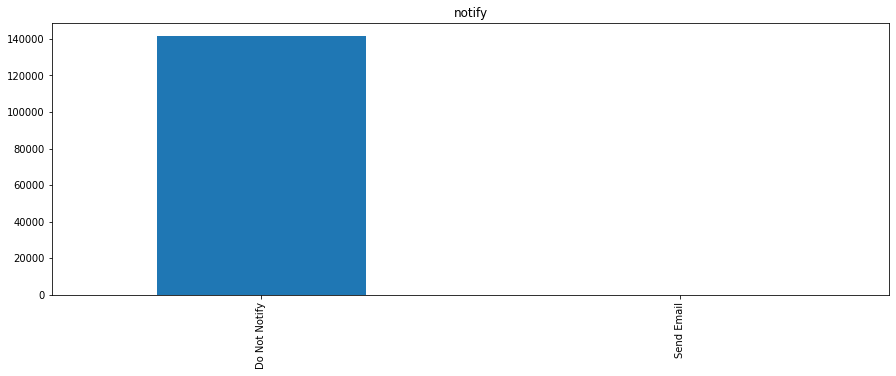

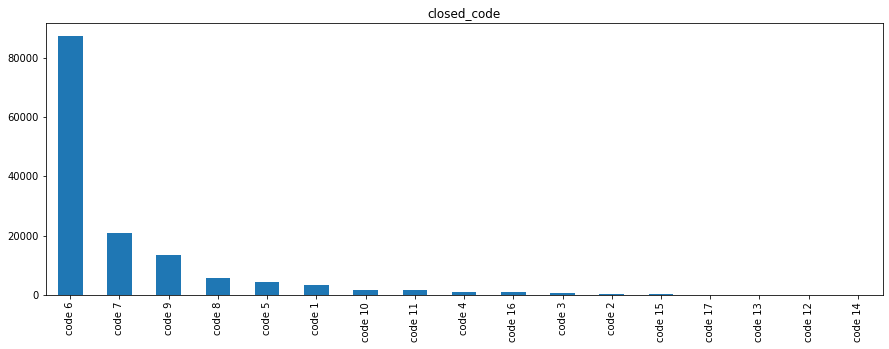

In [219]:
# lets check percentage of categories 

for feat in feat_category:
    data1[feat].value_counts().plot(kind="bar", title=feat, figsize=(15,5))
    plt.show()

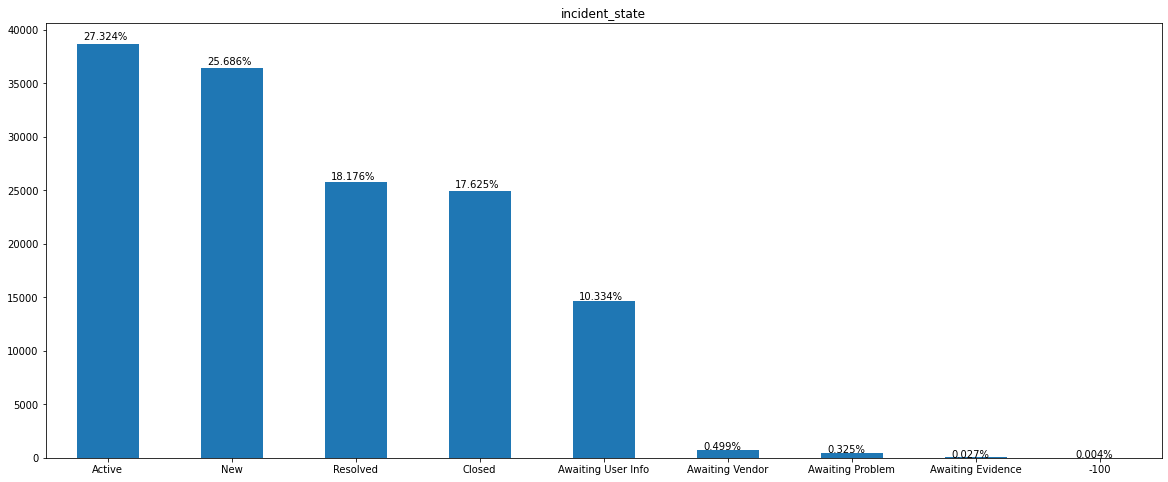

Active                27.323932
New                   25.686416
Resolved              18.175722
Closed                17.625178
Awaiting User Info    10.333997
Awaiting Vendor        0.499019
Awaiting Problem       0.325386
Awaiting Evidence      0.026821
-100                   0.003529
Name: incident_state, dtype: float64

In [220]:
isc=data1['incident_state'].value_counts().plot(kind="bar",rot=0, title='incident_state', figsize=(20,8))
total = len(data1['incident_state'])
for p in isc.patches:
        percentage = '{:.3f}%'.format(100* p.get_height()/total)
        x = p.get_x() + p.get_width()/10
        y = p.get_y() + p.get_height()*1.01
        isc.annotate(percentage, (x, y))

plt.show()
data1['incident_state'].value_counts()/len(data1['incident_state'])*100

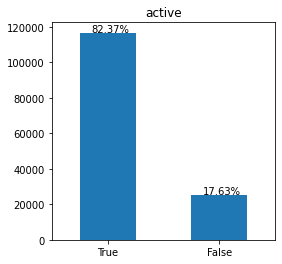

True     82.374116
False    17.625884
Name: active, dtype: float64

In [221]:
acc=data1['active'].value_counts().plot(kind="bar", title='active',rot=0, figsize=(4,4))
total = len(data1['active'])
for p in acc.patches:
        percentage = '{:.2f}%'.format(100* p.get_height()/total)
        x = p.get_x() + p.get_width()/5
        y = p.get_y() + p.get_height()+500
        acc.annotate(percentage, (x, y))

plt.show()
data1['active'].value_counts()/len(data1['active'])*100

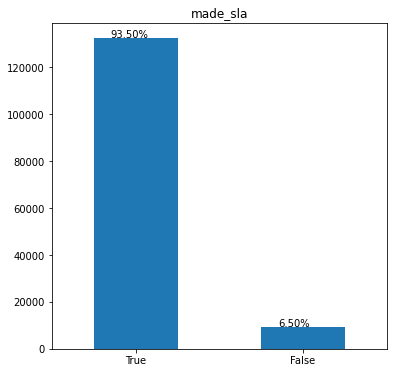

True     93.495814
False     6.504186
Name: made_sla, dtype: float64

In [222]:
mslac=data1['made_sla'].value_counts().plot(kind="bar",rot=0, title='made_sla', figsize=(6,6))
total = len(data1['made_sla'])
for p in mslac.patches:
        percentage = '{:.2f}%'.format(100* p.get_height()/total)
        x = p.get_x() + p.get_width()/5
        y = p.get_y() + p.get_height()+500
        mslac.annotate(percentage, (x, y))

plt.show()
data1['made_sla'].value_counts()/len(data1['made_sla'])*100

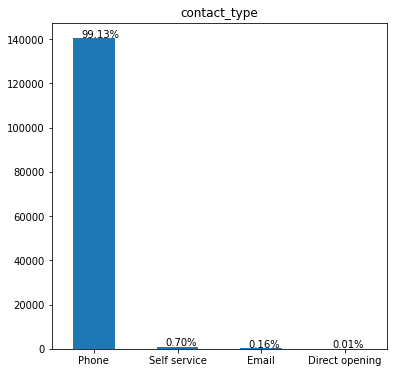

Phone             99.130423
Self service       0.702297
Email              0.155282
Direct opening     0.011999
Name: contact_type, dtype: float64

In [223]:
ctcc=data1['contact_type'].value_counts().plot(kind="bar",rot=0, title='contact_type', figsize=(6,6))
total = len(data1['contact_type'])
for p in ctcc.patches:
        percentage = '{:.2f}%'.format(100* p.get_height()/total)
        x = p.get_x() + p.get_width()/5
        y = p.get_y() + p.get_height()+500
        ctcc.annotate(percentage, (x, y))

plt.show()
data1['contact_type'].value_counts()/len(data1['contact_type'])*100

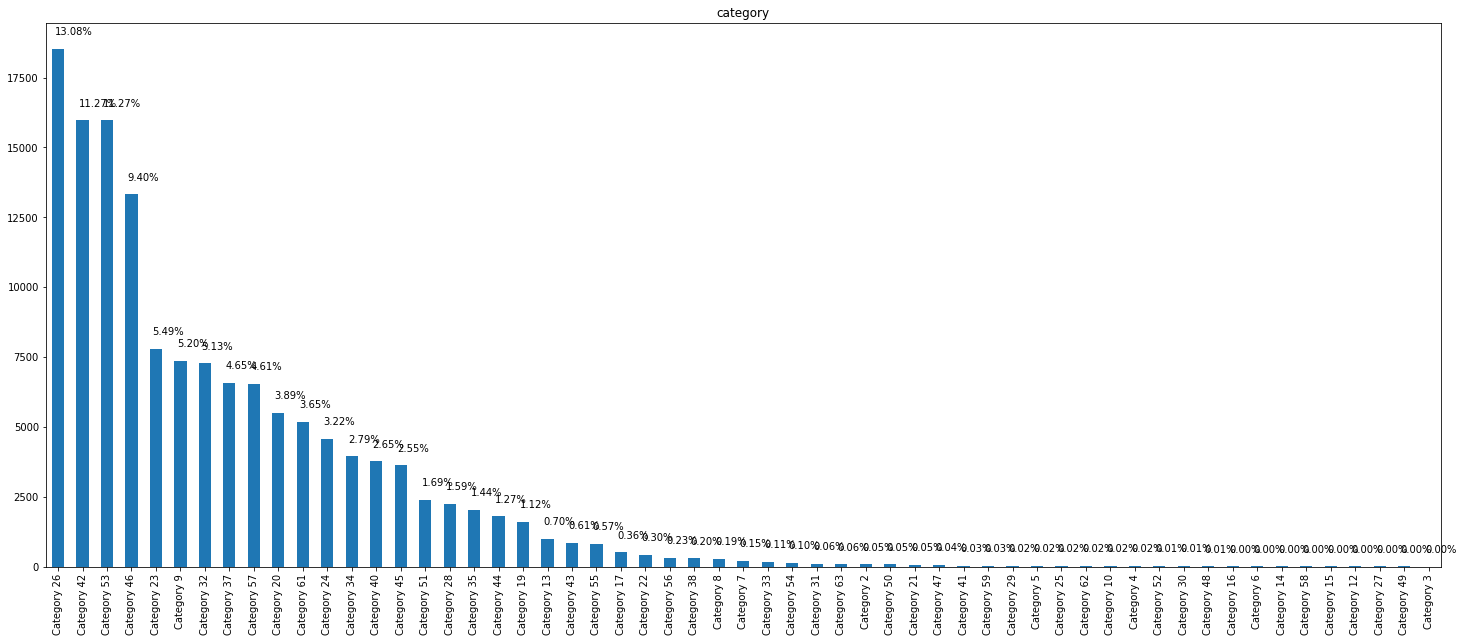

Category 26    13.078248
Category 42    11.273451
Category 53    11.270628
Category 46     9.404424
Category 23     5.490620
Category 9      5.198408
Category 32     5.133472
Category 37     4.647158
Category 57     4.610455
Category 20     3.886277
Category 61     3.647708
Category 24     3.219272
Category 34     2.785189
Category 40     2.653905
Category 45     2.554384
Category 51     1.686924
Category 28     1.592343
Category 35     1.437062
Category 44     1.269075
Category 19     1.123675
Category 13     0.701591
Category 43     0.605599
Category 55     0.565367
Category 17     0.361383
Category 22     0.296447
Category 56     0.227276
Category 38     0.204690
Category 8      0.186338
Category 7      0.146106
Category 33     0.112932
Category 54     0.098110
Category 31     0.064936
Category 63     0.055054
Category 2      0.054349
Category 50     0.052937
Category 21     0.048702
Category 47     0.035291
Category 41     0.025410
Category 59     0.025410
Category 29     0.022586


In [224]:
ctcc=data1['category'].value_counts().plot(kind="bar" ,title='category', figsize=(25,10))
total = len(data1['category'])
for p in ctcc.patches:
        percentage = '{:.2f}%'.format(100* p.get_height()/total)
        x = p.get_x() + p.get_width()/5
        y = p.get_y() + p.get_height()+500
        ctcc.annotate(percentage, (x, y))

plt.show()
data1['category'].value_counts()/len(data1['category'])*100

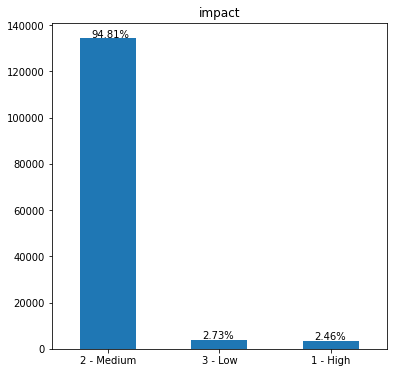

2 - Medium    94.805827
3 - Low        2.730135
1 - High       2.464038
Name: impact, dtype: float64

In [225]:
impcc=data1['impact'].value_counts().plot(kind="bar",rot=0, title='impact', figsize=(6,6))
total = len(data1['impact'])
for p in impcc.patches:
        percentage = '{:.2f}%'.format(100* p.get_height()/total)
        x = p.get_x() + p.get_width()/5
        y = p.get_y() + p.get_height()+500
        impcc.annotate(percentage, (x, y))

plt.show()
data1['impact'].value_counts()/len(data1['impact'])*100

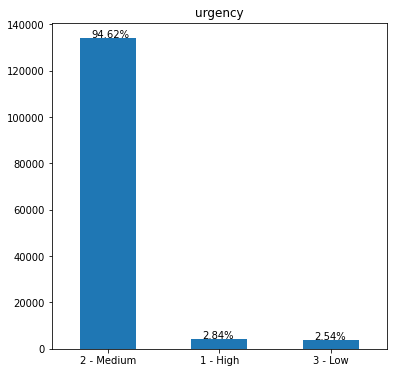

2 - Medium    94.623018
1 - High       2.837420
3 - Low        2.539562
Name: urgency, dtype: float64

In [226]:
urgcc=data1['urgency'].value_counts().plot(kind="bar",rot=0, title='urgency', figsize=(6,6))
total = len(data1['urgency'])
for p in urgcc.patches:
        percentage = '{:.2f}%'.format(100* p.get_height()/total)
        x = p.get_x() + p.get_width()/5
        y = p.get_y() + p.get_height()+500
        urgcc.annotate(percentage, (x, y))

plt.show()
data1['urgency'].value_counts()/len(data1['urgency'])*100

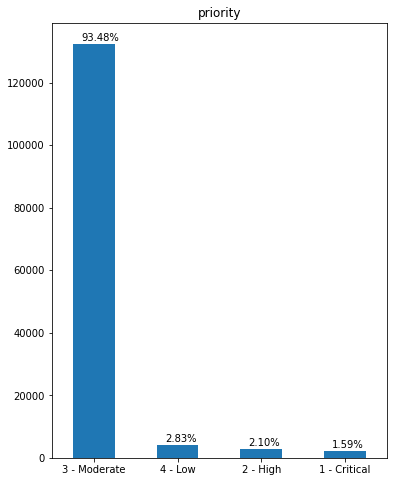

3 - Moderate    93.476757
4 - Low          2.831773
2 - High         2.097715
1 - Critical     1.593755
Name: priority, dtype: float64

In [227]:
pricc=data1['priority'].value_counts().plot(kind="bar",rot=0, title='priority', figsize=(6,8))
total = len(data1['priority'])
for p in pricc.patches:
        percentage = '{:.2f}%'.format(100* p.get_height()/total)
        x = p.get_x() + p.get_width()/5
        y = p.get_y() + p.get_height()+1000
        pricc.annotate(percentage, (x, y))

plt.show()
data1['priority'].value_counts()/len(data1['priority'])*100

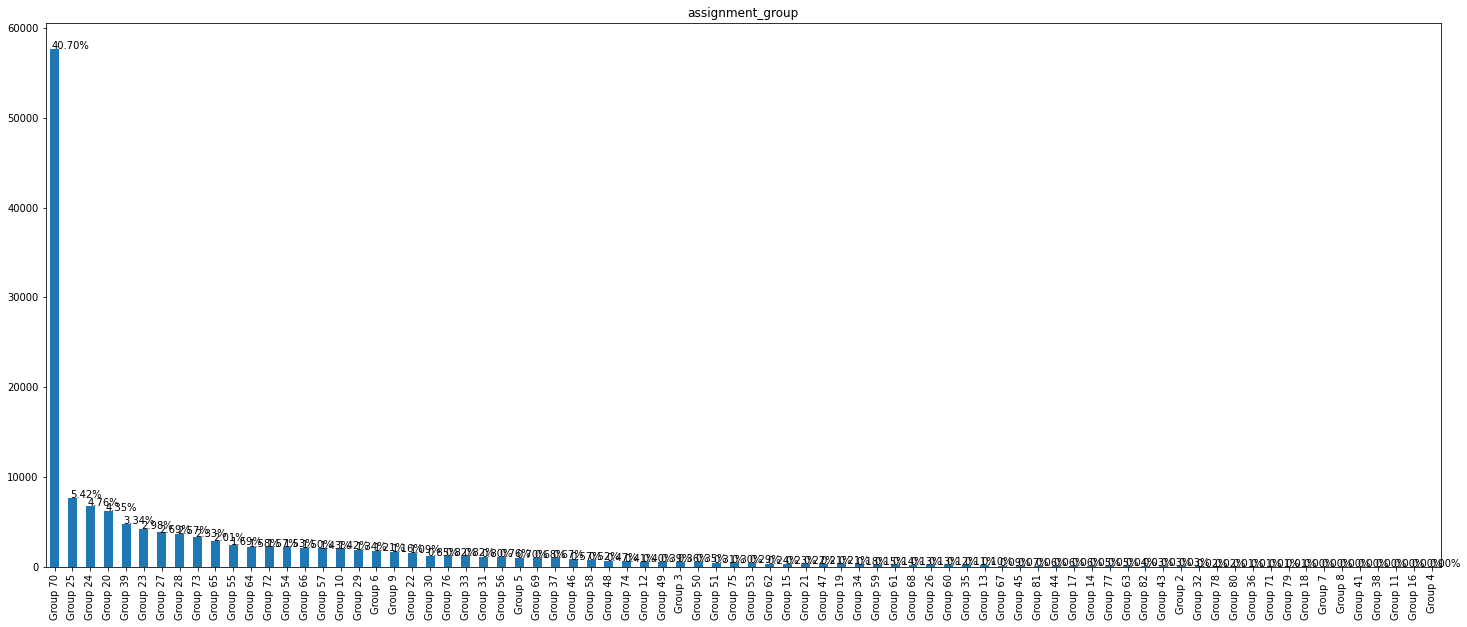

Group 70    40.700744
Group 25     5.420037
Group 24     4.762913
Group 20     4.354946
Group 39     3.337145
              ...    
Group 41     0.002117
Group 38     0.001412
Group 11     0.000706
Group 16     0.000706
Group 4      0.000706
Name: assignment_group, Length: 78, dtype: float64

In [228]:
asggrcc=data1['assignment_group'].value_counts().plot(kind="bar", title='assignment_group', figsize=(25,10))
total = len(data1['assignment_group'])
for p in asggrcc.patches:
        percentage = '{:.2f}%'.format(100* p.get_height()/total)
        x = p.get_x() + p.get_width()/5
        y = p.get_y() + p.get_height()
        asggrcc.annotate(percentage, (x, y))

plt.show()
data1['assignment_group'].value_counts()/len(data1['assignment_group'])*100

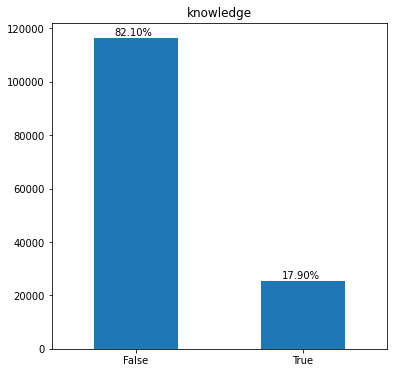

False    82.101667
True     17.898333
Name: knowledge, dtype: float64

In [229]:
knowcc=data1['knowledge'].value_counts().plot(kind="bar",rot=0, title='knowledge', figsize=(6,6))
total = len(data1['knowledge'])
for p in knowcc.patches:
        percentage = '{:.2f}%'.format(100* p.get_height()/total)
        x = p.get_x() + p.get_width()/4
        y = p.get_y() + p.get_height()+1000
        knowcc.annotate(percentage, (x, y))

plt.show()
data1['knowledge'].value_counts()/len(data1['knowledge'])*100

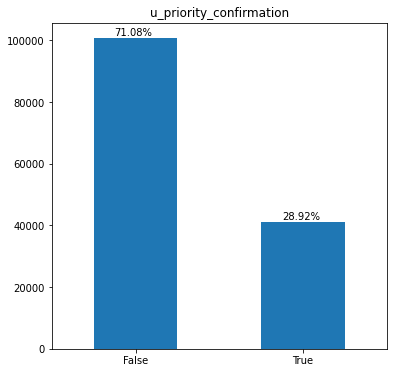

False    71.080902
True     28.919098
Name: u_priority_confirmation, dtype: float64

In [230]:
knowcc=data1['u_priority_confirmation'].value_counts().plot(kind="bar",rot=0, title='u_priority_confirmation', figsize=(6,6))
total = len(data1['u_priority_confirmation'])
for p in knowcc.patches:
        percentage = '{:.2f}%'.format(100* p.get_height()/total)
        x = p.get_x() + p.get_width()/4
        y = p.get_y() + p.get_height()+1000
        knowcc.annotate(percentage, (x, y))

plt.show()
data1['u_priority_confirmation'].value_counts()/len(data1['u_priority_confirmation'])*100

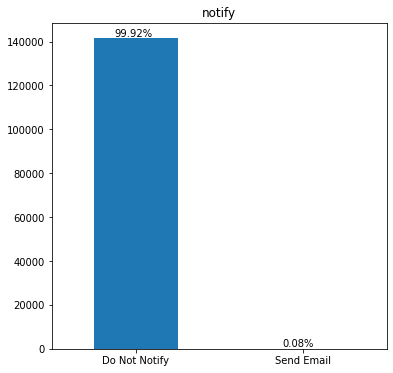

Do Not Notify    99.916007
Send Email        0.083993
Name: notify, dtype: float64

In [231]:
notcc=data1['notify'].value_counts().plot(kind="bar",rot=0, title='notify', figsize=(6,6))
total = len(data1['notify'])
for p in notcc.patches:
        percentage = '{:.2f}%'.format(100* p.get_height()/total)
        x = p.get_x() + p.get_width()/4
        y = p.get_y() + p.get_height()+1000
        notcc.annotate(percentage, (x, y))

plt.show()
data1['notify'].value_counts()/len(data1['notify'])*100

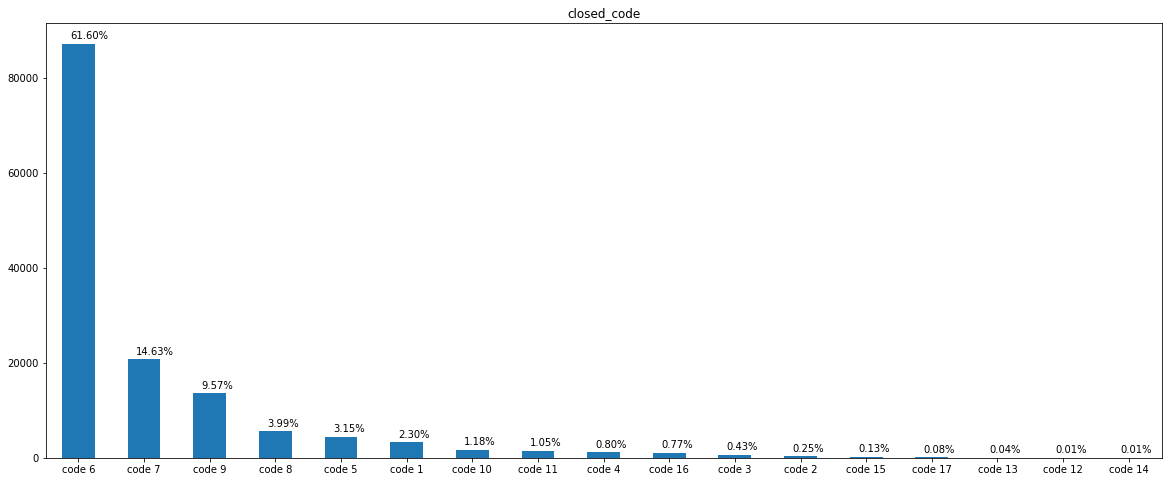

code 6     61.596013
code 7     14.632476
code 9      9.572411
code 8      3.985093
code 5      3.154336
code 1      2.302404
code 10     1.184376
code 11     1.053798
code 4      0.803936
code 16     0.770056
code 3      0.429142
code 2      0.246333
code 15     0.129166
code 17     0.081170
code 13     0.041644
code 12     0.009176
code 14     0.008470
Name: closed_code, dtype: float64

In [232]:
clococc=data1['closed_code'].value_counts().plot(kind="bar",rot=0, title='closed_code', figsize=(20,8))
total = len(data1['closed_code'])
for p in clococc.patches:
        percentage = '{:.2f}%'.format(100* p.get_height()/total)
        x = p.get_x() + p.get_width()/4
        y = p.get_y() + p.get_height()+1000
        clococc.annotate(percentage, (x, y))

plt.show()
data1['closed_code'].value_counts()/len(data1['closed_code'])*100

#### number:

In [233]:
feat_category = data1[feat_cat].nunique()[data1[feat_cat].nunique()<=600].index.tolist()
feat_others = data1[feat_cat].nunique()[data1[feat_cat].nunique()>600].index.tolist()

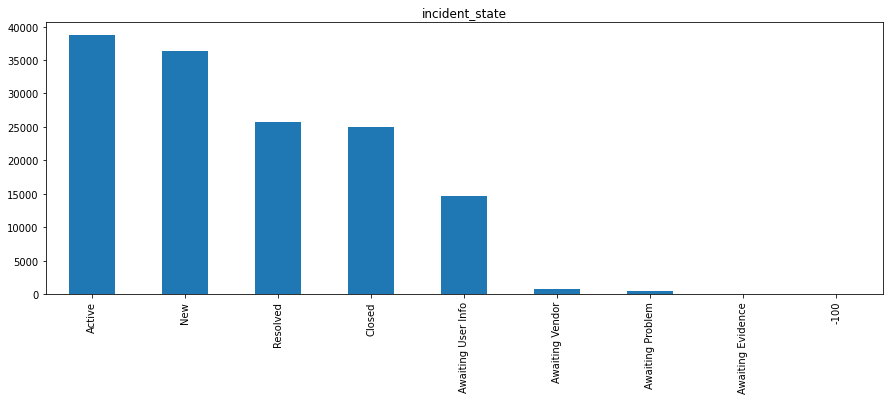

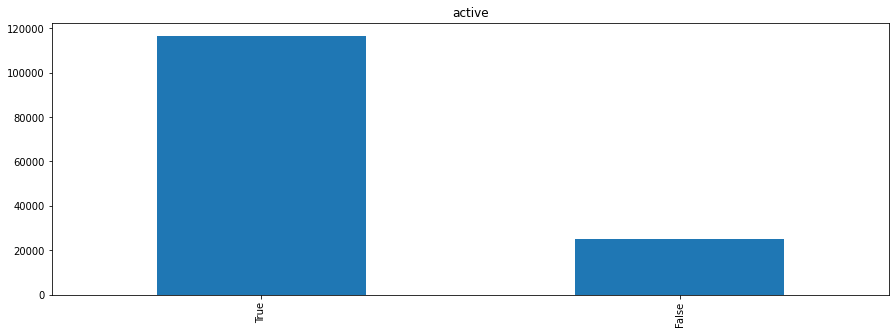

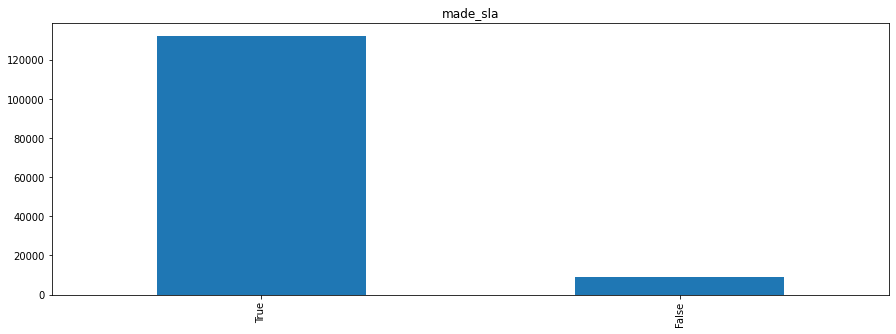

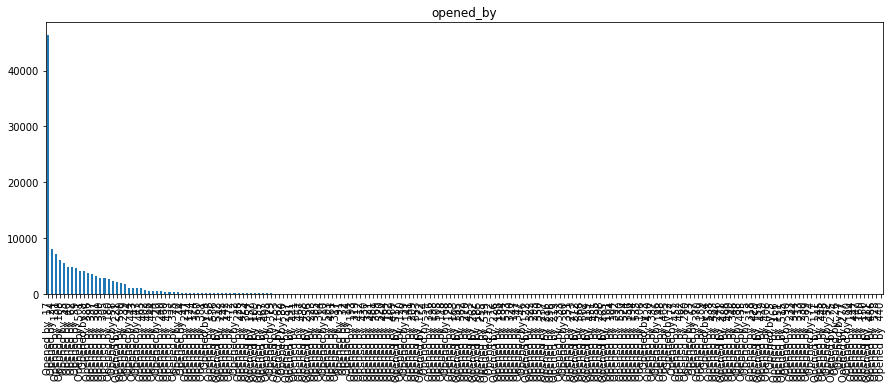

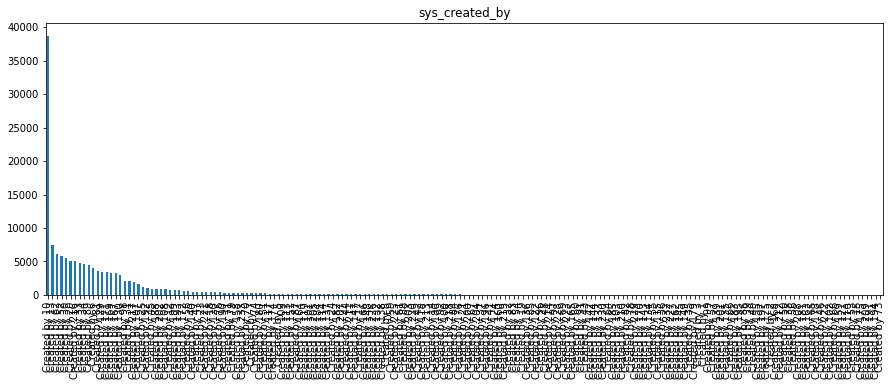

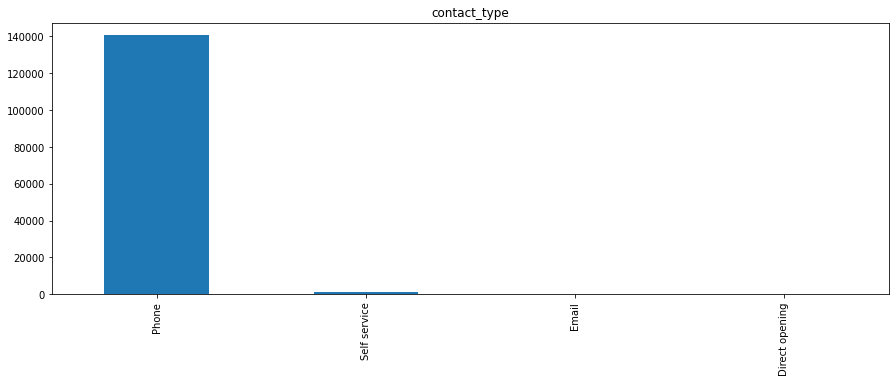

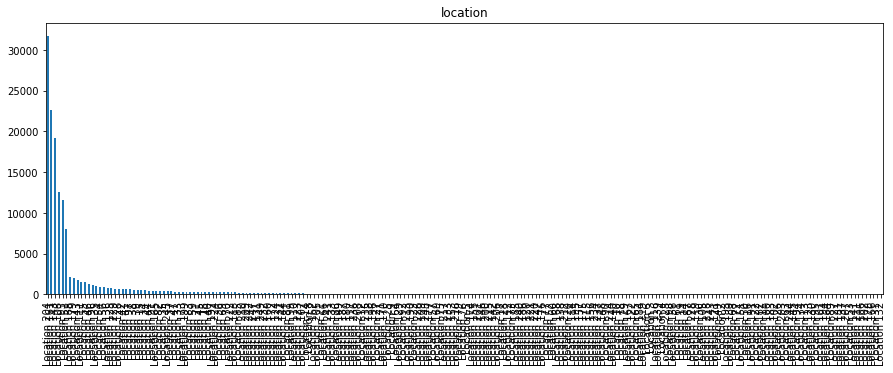

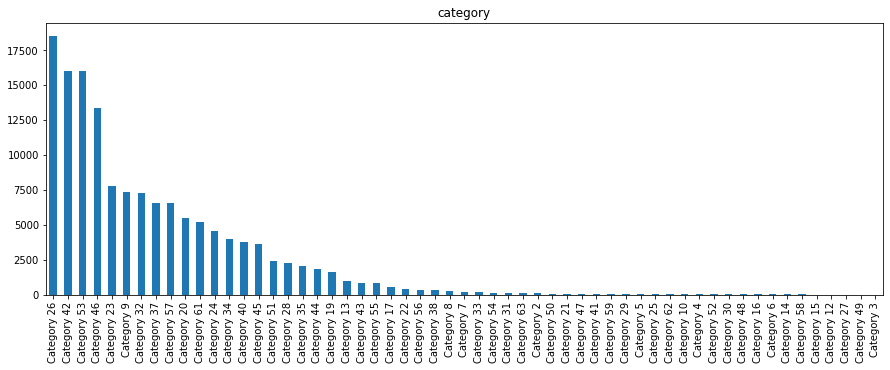

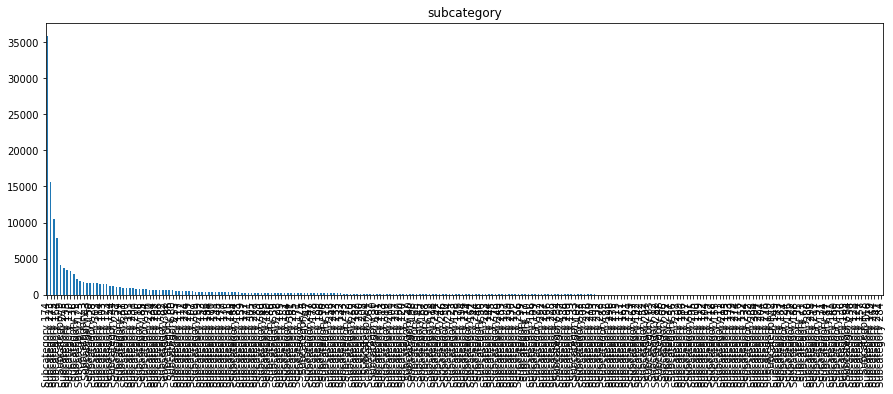

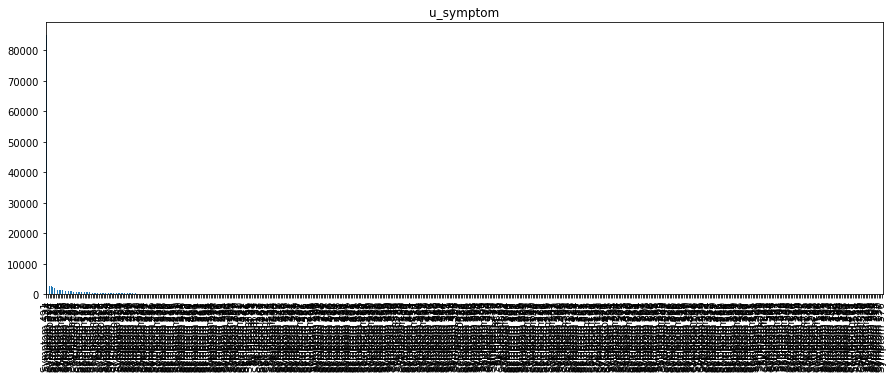

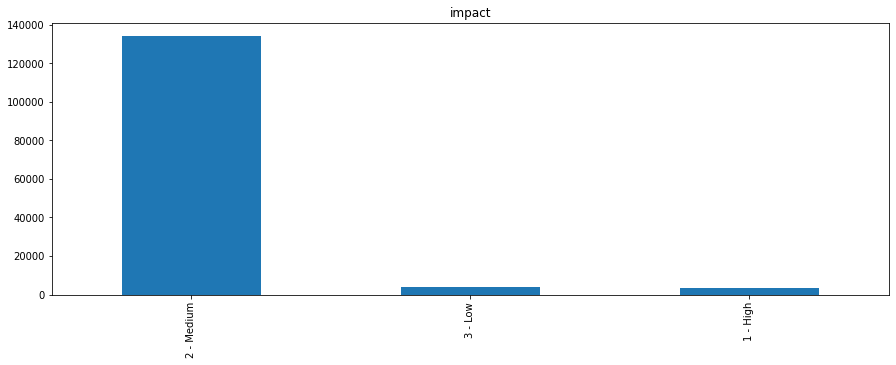

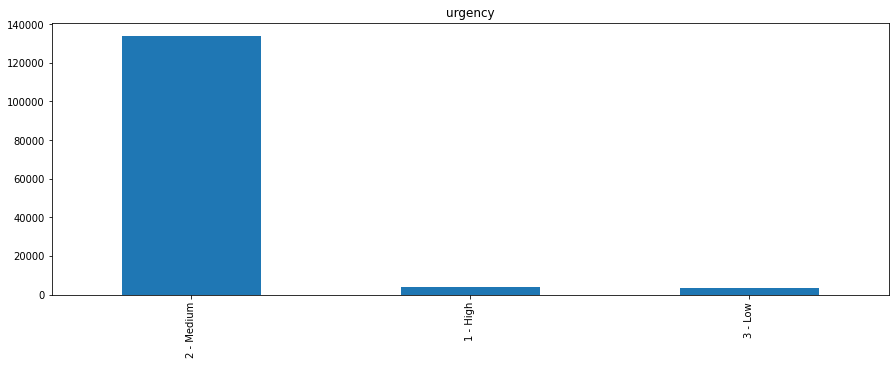

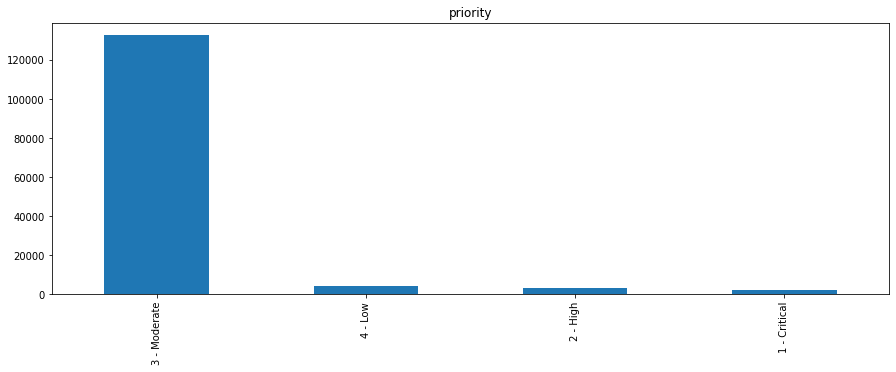

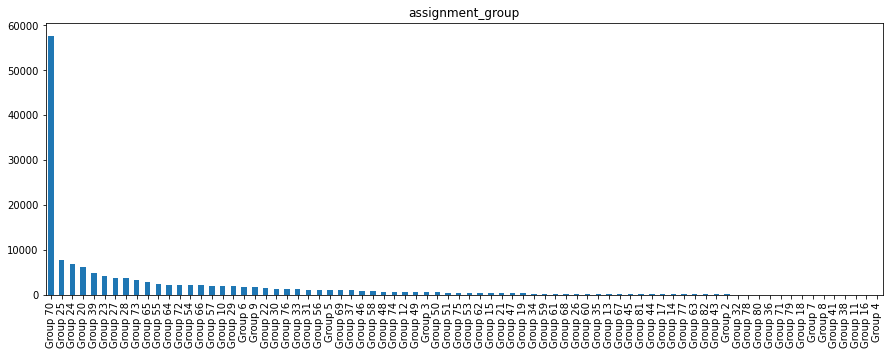

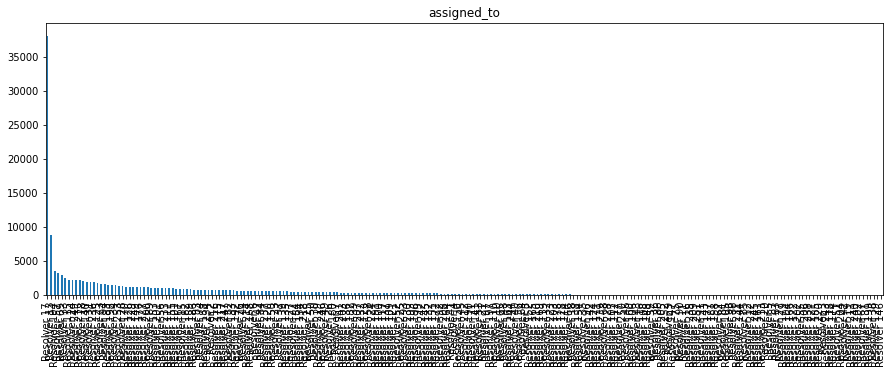

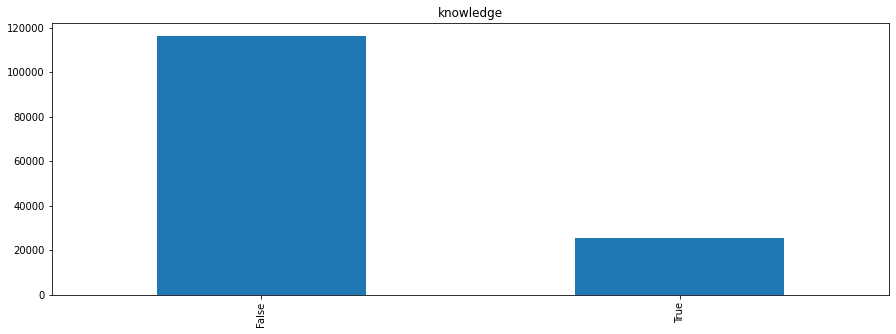

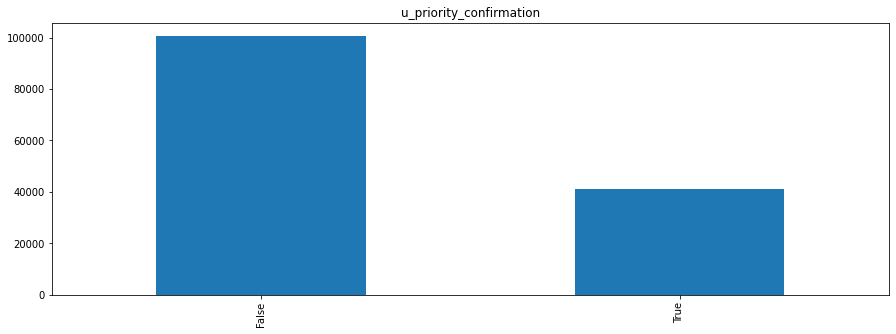

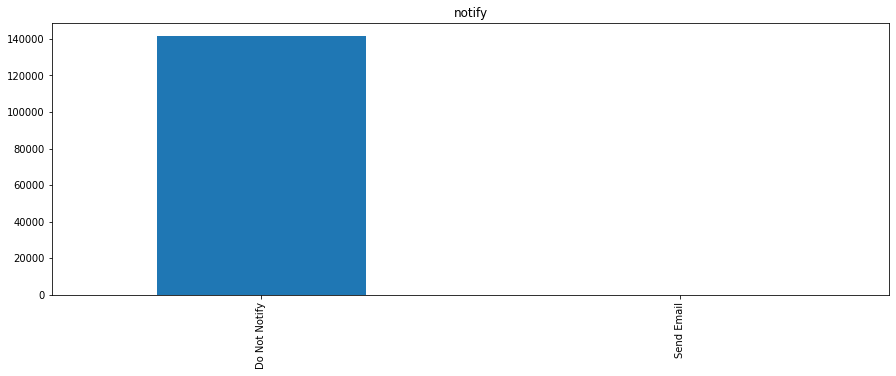

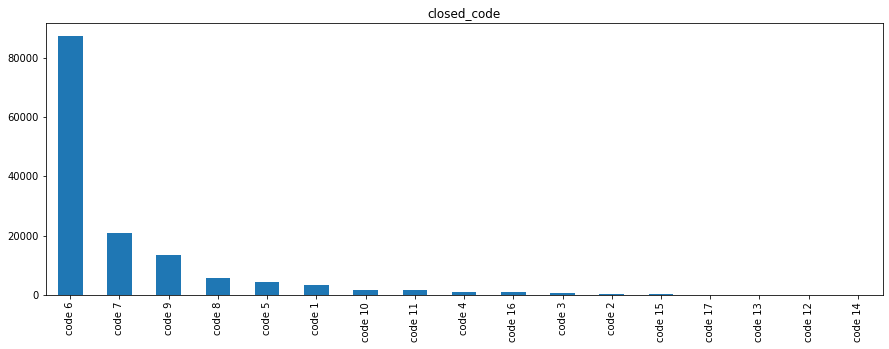

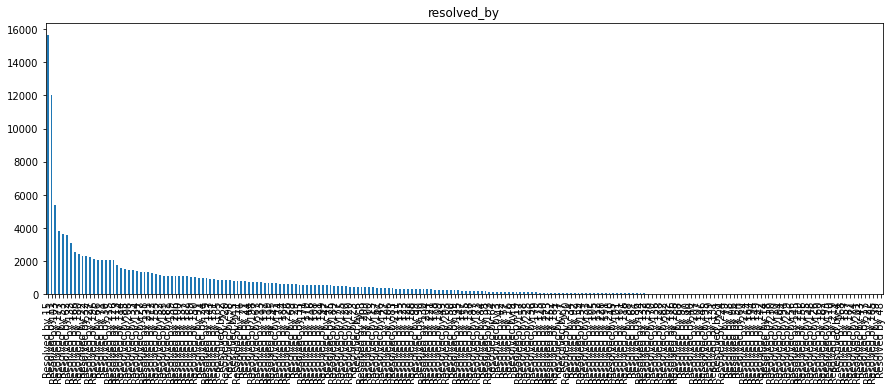

In [236]:
# lets check percentage of categories 

for feat in feat_category:
    data1[feat].value_counts().plot(kind="bar", title=feat, figsize=(15,5))
    plt.show()

**Inference:**
    - `incident_state` : we have 9 different states of incident
    - `active` : we have True / False
    - `opened_by`, `sys_created_by`: 
    
    

## incident_state

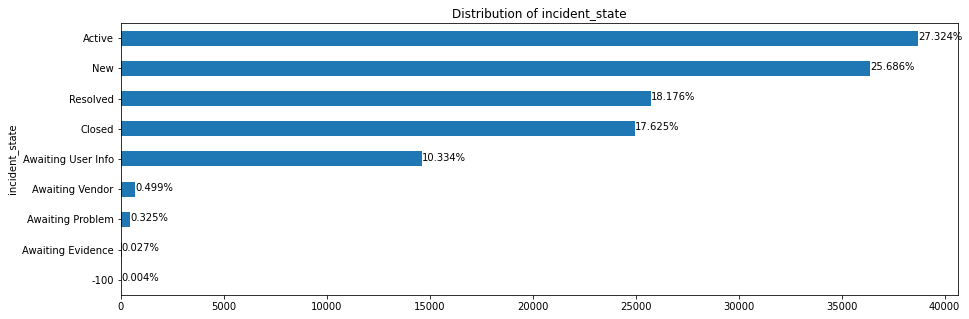

Active                27.323932
New                   25.686416
Resolved              18.175722
Closed                17.625178
Awaiting User Info    10.333997
Awaiting Vendor        0.499019
Awaiting Problem       0.325386
Awaiting Evidence      0.026821
-100                   0.003529
Name: incident_state, dtype: float64

In [237]:
# checking different incidents
inc=data1.groupby('incident_state') \
    .count()['number'] .sort_values(ascending=True)\
    .plot(kind='barh',
          title='Distribution of incident_state',
          figsize=(15, 5))
total = len(data1['incident_state'])
for p in inc.patches:
        percentage = '{:.3f}%'.format(100* p.get_width()/total)
        x = p.get_x() + p.get_width()+1
        y = p.get_y() + p.get_height()*0.4
        inc.annotate(percentage, (x, y))

plt.show()
data1['incident_state'].value_counts()/len(data1['incident_state'])*100

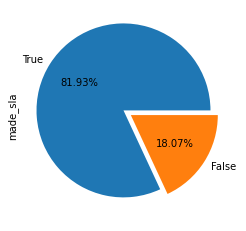

True     81.932889
False    18.067111
Name: made_sla, dtype: float64

In [238]:
# checking which incidents made sla
made_s=data1[(data1['incident_state']=='Closed')|(data1['incident_state']=='Resolved')]
made_s['made_sla'].value_counts().plot(kind='pie',autopct='%0.2f%%',explode=[0.1,0])
plt.show()
made_s['made_sla'].value_counts()/len(made_s['made_sla'])*100

In [239]:
made_s

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,closed_code,resolved_by,resolved_at,closed_at,predicted_closed_days,days_took_to_sys_created,days_took_to_sys_updated,opened_month,opened_day,opened_hour,opened_minute,sys_updated_month,sys_updated_day,sys_updated_hour,sys_updated_minute,sys_created_month,sys_created_day,sys_created_hour,sys_created_minute
1,INC0000045,Resolved,True,0.0,0,1.414214,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,Created by 6,2016-02-29 01:23:00,Updated by 642,2016-02-29 08:53:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,2 - Medium,2 - Medium,3 - Moderate,Group 56,Resolver 17,True,False,Do Not Notify,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00,5.447222,0.004861,0.312500,2,29,1,16,2,29,8,53,2,29,1,23
2,INC0000045,Resolved,True,0.0,0,1.732051,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,Created by 6,2016-02-29 01:23:00,Updated by 804,2016-02-29 11:29:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,2 - Medium,2 - Medium,3 - Moderate,Group 56,Resolver 17,True,False,Do Not Notify,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00,5.447222,0.004861,0.420833,2,29,1,16,2,29,11,29,2,29,1,23
3,INC0000045,Closed,False,0.0,0,2.000000,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,Created by 6,2016-02-29 01:23:00,Updated by 908,2016-03-05 12:00:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,2 - Medium,2 - Medium,3 - Moderate,Group 56,Resolver 17,True,False,Do Not Notify,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00,5.447222,0.004861,5.442361,2,29,1,16,3,5,12,0,2,29,1,23
11,INC0000047,Resolved,True,1.0,0,2.645751,True,Caller 2403,Opened by 397,2016-02-29 04:40:00,Created by 171,2016-02-29 04:57:00,Updated by 332,2016-03-01 09:52:00,Phone,Location 165,Category 40,Subcategory 215,Symptom 471,2 - Medium,2 - Medium,3 - Moderate,Group 24,Resolver 89,True,False,Do Not Notify,code 5,Resolved by 81,2016-03-01 09:52:00,2016-03-06 10:00:00,6.222222,0.011806,1.204861,2,29,4,40,3,1,9,52,2,29,4,57
12,INC0000047,Closed,False,1.0,0,2.828427,True,Caller 2403,Opened by 397,2016-02-29 04:40:00,Created by 171,2016-02-29 04:57:00,Updated by 908,2016-03-06 10:00:00,Phone,Location 165,Category 40,Subcategory 215,Symptom 471,2 - Medium,2 - Medium,3 - Moderate,Group 24,Resolver 89,True,False,Do Not Notify,code 5,Resolved by 81,2016-03-01 09:52:00,2016-03-06 10:00:00,6.222222,0.011806,6.210417,2,29,4,40,3,6,10,0,2,29,4,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141669,INC0120304,Closed,False,0.0,0,1.414214,True,Caller 90,Opened by 8,2017-02-15 02:02:00,Created by 74,2017-02-15 02:02:00,Updated by 21,2017-02-17 00:50:00,Email,Location 188,Category 52,Subcategory 177,Symptom 494,2 - Medium,2 - Medium,3 - Moderate,Group 64,Resolver 6,False,True,Do Not Notify,code 6,Resolved by 5,2017-02-17 00:47:00,2017-02-17 00:50:00,1.950000,0.000000,1.950000,2,15,2,2,2,17,0,50,2,15,2,2
141672,INC0120835,Resolved,True,1.0,0,1.732051,True,Caller 116,Opened by 12,2017-02-16 09:09:00,Created by 74,2017-02-16 09:09:00,Updated by 27,2017-02-16 09:53:00,Email,Location 204,Category 42,Subcategory 223,Symptom 494,2 - Medium,2 - Medium,3 - Moderate,Group 31,Resolver 10,False,True,Do Not Notify,code 9,Resolved by 9,2017-02-16 09:53:00,2017-02-16 09:53:00,0.030556,0.000000,0.030556,2,16,9,9,2,16,9,53,2,16,9,9
141673,INC0120835,Closed,False,1.0,0,2.000000,True,Caller 116,Opened by 12,2017-02-16 09:09:00,Created by 74,2017-02-16 09:09:00,Updated by 27,2017-02-16 09:53:00,Email,Location 204,Category 42,Subcategory 223,Symptom 494,2 - Medium,2 - Medium,3 - Mo

**Inference:**
    Majority incidents which were in closed/resolved made_sla only few incidents did not make sla timeline.

### Checking what was the reopen count for incidents which did not make_sla

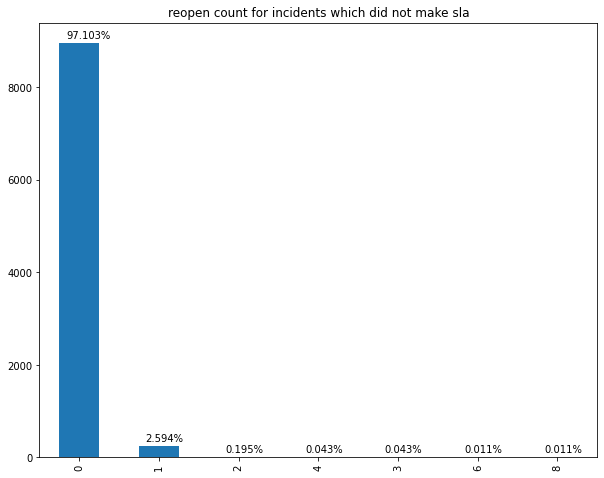

0    97.102550
1     2.593597
2     0.195334
4     0.043407
3     0.043407
6     0.010852
8     0.010852
Name: reopen_count, dtype: float64

In [240]:
rep=data1[data1.made_sla==False]['reopen_count'].value_counts().plot(kind='bar',figsize=(10,8), title='reopen count for incidents which did not make sla')
total = len(data1[data1.made_sla==False]['reopen_count'])
for p in rep.patches:
        percentage = '{:.3f}%'.format(100* p.get_height()/total)
        x = p.get_x() + p.get_width()/6
        y = p.get_y() + p.get_height()+100
        rep.annotate(percentage, (x, y))

plt.show()
data1[data1.made_sla==False]['reopen_count'].value_counts()/len(data1[data1.made_sla==False]['reopen_count'])*100

In [241]:
data1[data1.made_sla==False]['reopen_count'].value_counts()

0    8948
1     239
2      18
4       4
3       4
6       1
8       1
Name: reopen_count, dtype: int64

**Inference:**
    We can see from plot we have a lot of incidents which did not make sla even if reopen count is 0.

#### closed_code

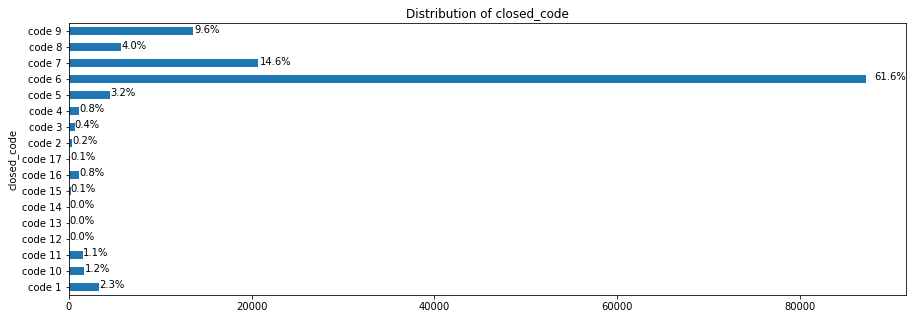

code 6     61.596013
code 7     14.632476
code 9      9.572411
code 8      3.985093
code 5      3.154336
code 1      2.302404
code 10     1.184376
code 11     1.053798
code 4      0.803936
code 16     0.770056
code 3      0.429142
code 2      0.246333
code 15     0.129166
code 17     0.081170
code 13     0.041644
code 12     0.009176
code 14     0.008470
Name: closed_code, dtype: float64

In [242]:
# checking different incidents
inclo=data1.groupby('closed_code') \
    .count()['number'] \
    .plot(kind='barh',
          title='Distribution of closed_code',
          figsize=(15, 5))
total = len(data1['closed_code'])
for p in inclo.patches:
        percentage = '{:.1f}%'.format(100* p.get_width()/total)
        x = p.get_x() + p.get_width()*1.01
        y = p.get_y() + p.get_height()/3
        inclo.annotate(percentage, (x, y))

plt.show()

data1['closed_code'].value_counts()/len(data1['closed_code'])*100

In [243]:
data1.columns

Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by',
       'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory',
       'u_symptom', 'impact', 'urgency', 'priority', 'assignment_group',
       'assigned_to', 'knowledge', 'u_priority_confirmation', 'notify',
       'closed_code', 'resolved_by', 'resolved_at', 'closed_at',
       'predicted_closed_days', 'days_took_to_sys_created',
       'days_took_to_sys_updated', 'opened_month', 'opened_day', 'opened_hour',
       'opened_minute', 'sys_updated_month', 'sys_updated_day',
       'sys_updated_hour', 'sys_updated_minute', 'sys_created_month',
       'sys_created_day', 'sys_created_hour', 'sys_created_minute'],
      dtype='object')

## Bivariate Analysis:

### made_sla vs predict_closed_days

Text(0.5, 1.0, 'made_sla vs predicted_closed_days')

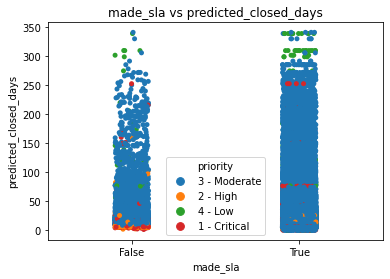

In [244]:
sns.stripplot(data1.made_sla, data1.predicted_closed_days, hue=data1.priority)
plt.title("made_sla vs predicted_closed_days")

**Inference:**
    We can see that whenever made_sla is True predicted_closed_days was lesser in comparision to when made_sla is False, 
    

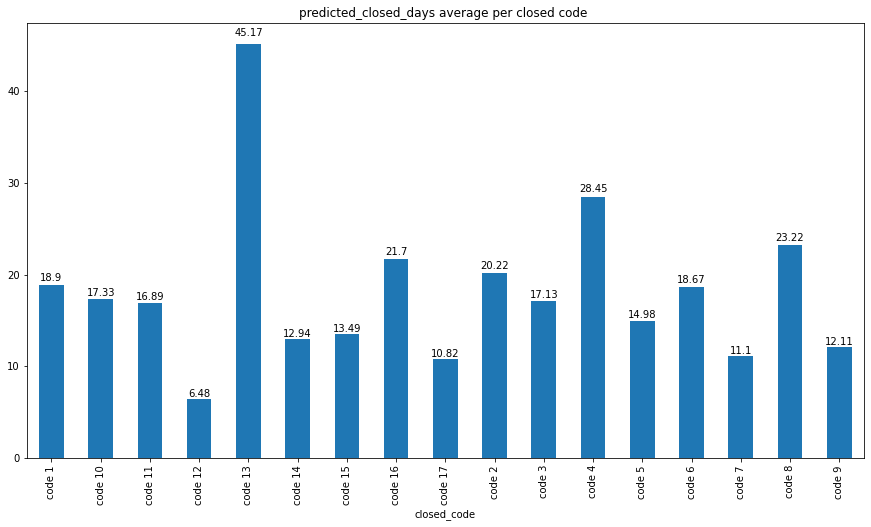

In [245]:
# data1.groupby('closed_code').describe()
# checking which types of closed state seem to have less days taken to be closed
pavg=round(data1.groupby('closed_code').mean()['predicted_closed_days'],2).plot(kind='bar',figsize=(15,8), title="predicted_closed_days average per closed code ")

for p in pavg.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    pavg.annotate(f'{height:1}', (x + width/2, y + height*1.02), ha='center')
plt.show()


In [246]:
data1.groupby('closed_code').mean()['predicted_closed_days']

closed_code
code 1     18.901997
code 10    17.332057
code 11    16.886911
code 12     6.483868
code 13    45.166502
code 14    12.935417
code 15    13.493579
code 16    21.700085
code 17    10.822621
code 2     20.218748
code 3     17.130550
code 4     28.452328
code 5     14.978292
code 6     18.671173
code 7     11.099064
code 8     23.221482
code 9     12.109519
Name: predicted_closed_days, dtype: float64

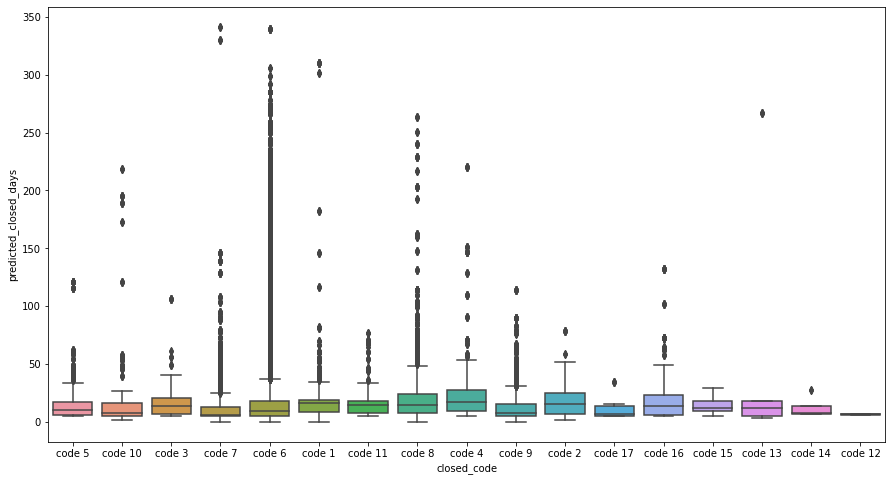

In [247]:
plt.figure(figsize=(15,8))

ccpcd=sns.boxplot(data1.closed_code, data1.predicted_closed_days)

plt.show()


**Inference:**
    - We can see code 12 hardly takes any number of days.
    - however code 13 seem to have the highest average
    - code 6 seems to have a lot of outliers sometimes it 

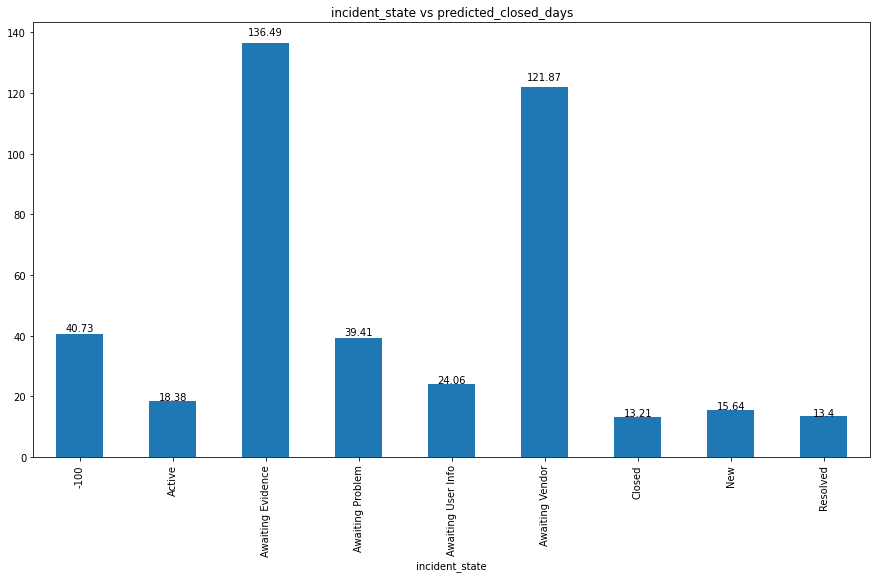

incident_state
-100                   40.731944
Active                 18.381884
Awaiting Evidence     136.492946
Awaiting Problem       39.408003
Awaiting User Info     24.057471
Awaiting Vendor       121.874008
Closed                 13.213828
New                    15.642914
Resolved               13.401626
Name: predicted_closed_days, dtype: float64

In [248]:
# checking distribution of incident state is that affects number of days it would take to predict closed_days
ispc=round(data1.groupby('incident_state').mean()['predicted_closed_days'],2).plot(kind='bar',figsize=(15,8), title='incident_state vs predicted_closed_days')
for p in ispc.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ispc.annotate(f'{height:1}', (x + width/2, y + height*1.02), ha='center')
plt.show()
data1.groupby('incident_state').mean()['predicted_closed_days']


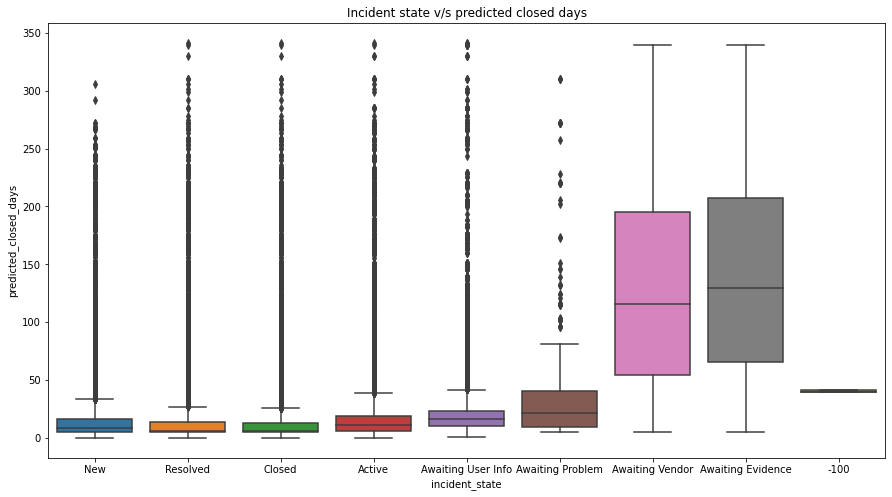

In [249]:
plt.figure(figsize=(15,8))
sns.boxplot(data1.incident_state, data1.predicted_closed_days)
plt.title("Incident state v/s predicted closed days")
plt.show()


**Inference:**
    We can see `Awaiting Vendor` and `Awaiting Evidence` seem to have higher number of days which also makes sense we we check the incidentstate

### Checking if category of incident's average time to get closed


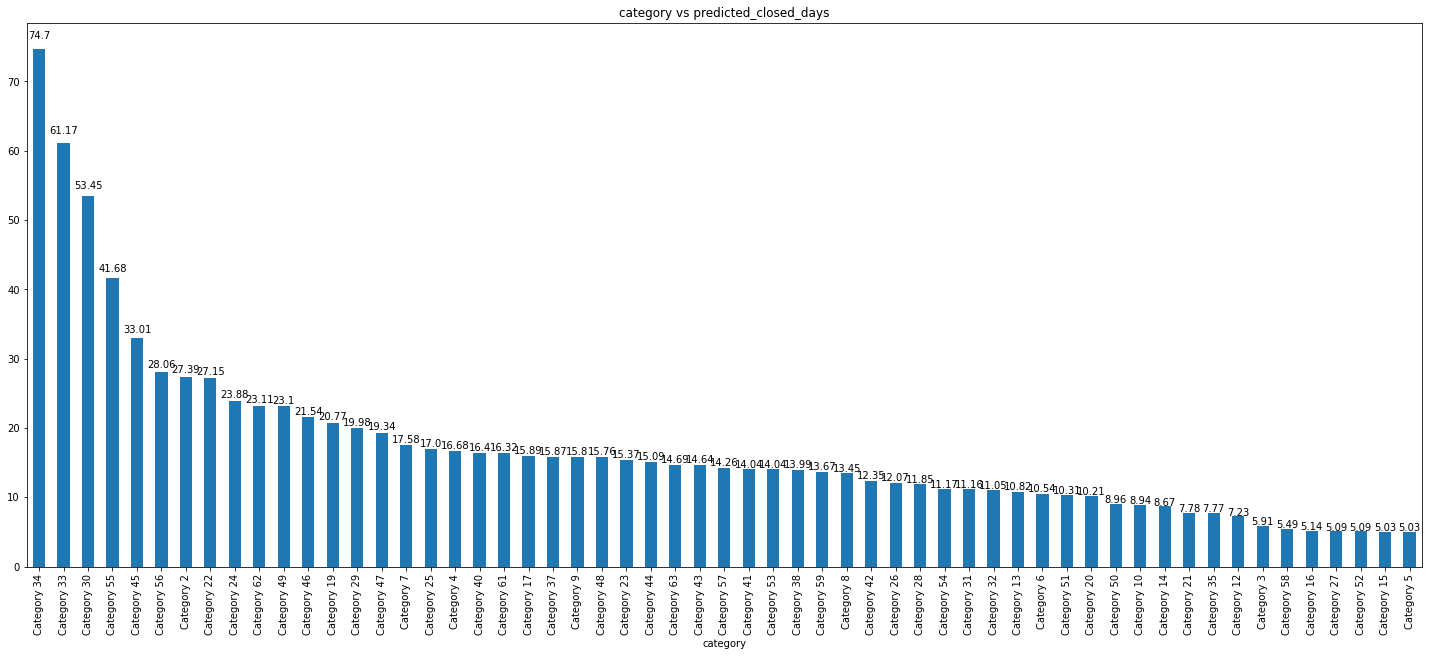

category
Category 34    74.701887
Category 33    61.173468
Category 30    53.450046
Category 55    41.684818
Category 45    33.006724
Category 56    28.057132
Category 2     27.390341
Category 22    27.149653
Category 24    23.876955
Category 62    23.107361
Category 49    23.097917
Category 46    21.543399
Category 19    20.770138
Category 29    19.984809
Category 47    19.341764
Category 7     17.582199
Category 25    17.002199
Category 4     16.681029
Category 40    16.404919
Category 61    16.321481
Category 17    15.890141
Category 37    15.872163
Category 9     15.803757
Category 48    15.762500
Category 23    15.371398
Category 44    15.088712
Category 63    14.688399
Category 43    14.643559
Category 57    14.264777
Category 41    14.043538
Category 53    14.037931
Category 38    13.985335
Category 59    13.665278
Category 8     13.454677
Category 42    12.346195
Category 26    12.066666
Category 28    11.845259
Category 54    11.173716
Category 31    11.159926
Category 32    1

In [250]:
catin=round(data1.groupby('category').mean()['predicted_closed_days'].sort_values(ascending=False),2).plot(kind='bar',figsize=(25,10), title='category vs predicted_closed_days')
for p in catin.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    catin.annotate(f'{height:1}', (x + width/2, y + height*1.02), ha='center')
plt.show()
data1.groupby('category').mean()['predicted_closed_days'].sort_values(ascending=False)

**Inference:**
    We can see few categories significantly take way longer than few  other categories ime category 34 on average takes around 70 days to be closed whereas category 36 only takes about 2 days.

### checking number of days taken by category-subcategory wise number of days taken to close it

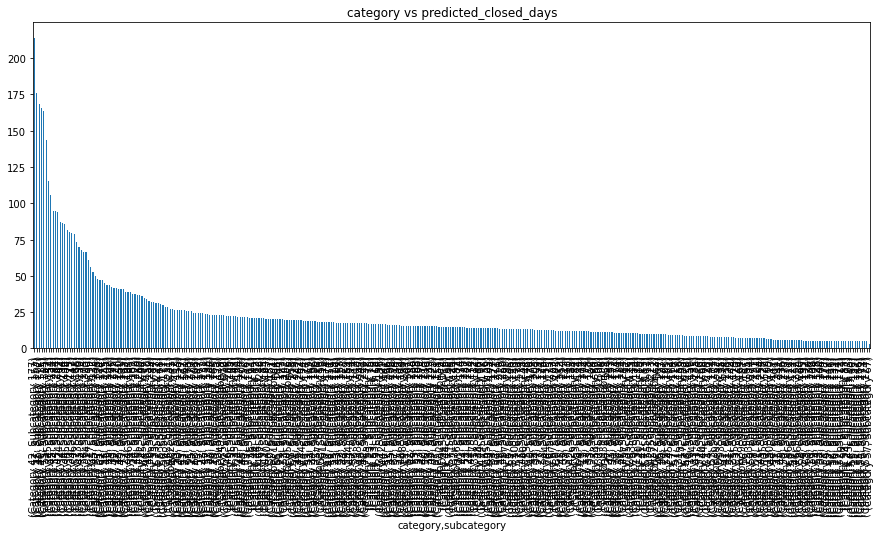

In [251]:
data1.groupby(['category', 'subcategory']).mean()['predicted_closed_days'].sort_values(ascending=False).plot(kind='bar', title='category vs predicted_closed_days', figsize=(15,6))

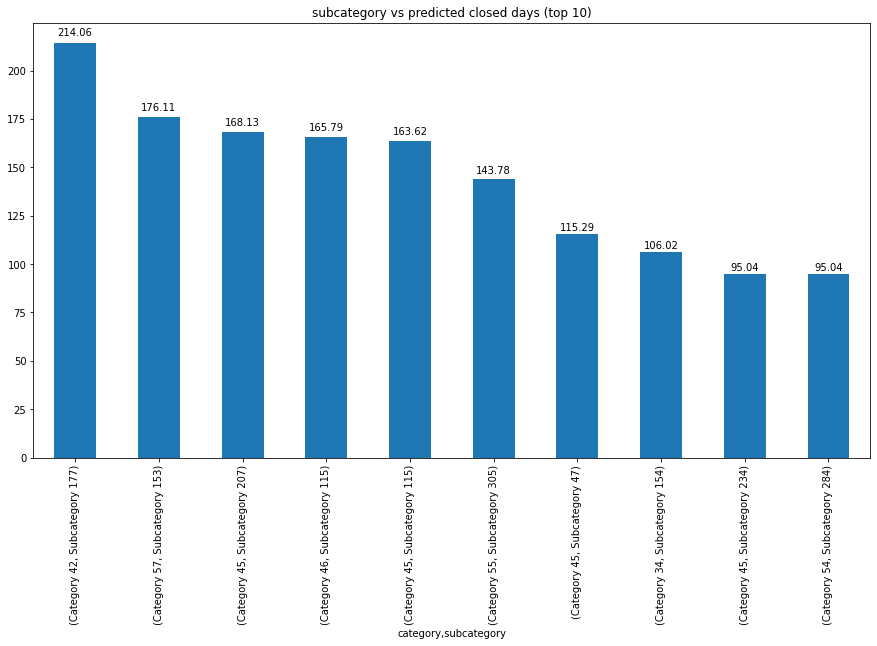

category     subcategory    
Category 42  Subcategory 177    214.056250
Category 57  Subcategory 153    176.109722
Category 45  Subcategory 207    168.125772
Category 46  Subcategory 115    165.790909
Category 45  Subcategory 115    163.620486
Category 55  Subcategory 305    143.779392
Category 45  Subcategory 47     115.288769
Category 34  Subcategory 154    106.016239
Category 45  Subcategory 234     95.043750
Category 54  Subcategory 284     95.043750
Name: predicted_closed_days, dtype: float64

In [252]:
#top 10
top10=round(data1.groupby(['category', 'subcategory']).mean()['predicted_closed_days'].sort_values(ascending=False).head(10),2).plot(kind='bar', title="subcategory vs predicted closed days (top 10)", figsize=(15,8))

for p in top10.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    top10.annotate(f'{height:1}', (x + width/2, y + height*1.02), ha='center')
plt.show()
data1.groupby(['category', 'subcategory']).mean()['predicted_closed_days'].sort_values(ascending=False).head(10)

category-subcategory which take least time to be closed


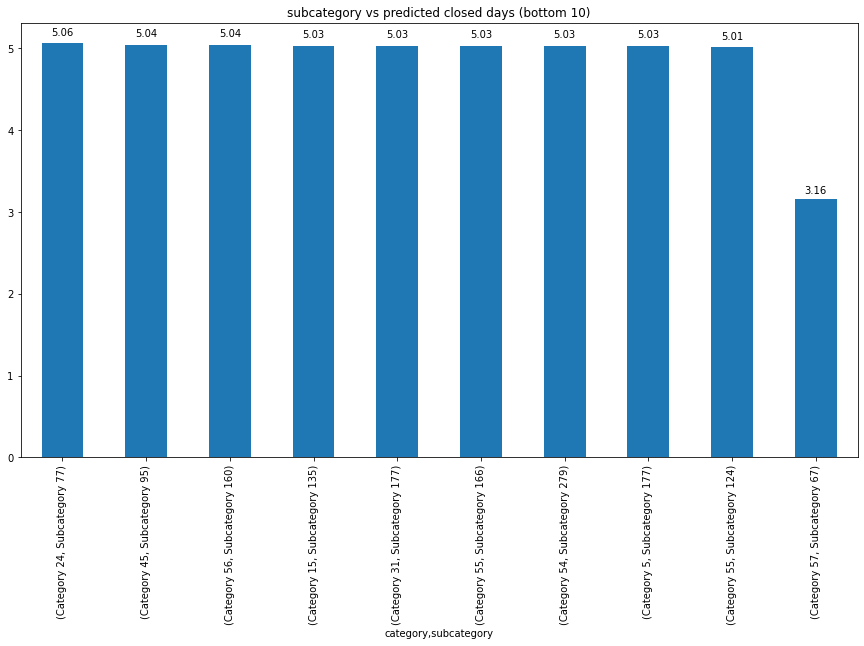

category     subcategory    
Category 24  Subcategory 77     5.060274
Category 45  Subcategory 95     5.044444
Category 56  Subcategory 160    5.037500
Category 15  Subcategory 135    5.032639
Category 31  Subcategory 177    5.032407
Category 55  Subcategory 166    5.031944
Category 54  Subcategory 279    5.027083
Category 5   Subcategory 177    5.025291
Category 55  Subcategory 124    5.007639
Category 57  Subcategory 67     3.155556
Name: predicted_closed_days, dtype: float64

In [253]:
#bottom 10
print("category-subcategory which take least time to be closed")
bot10=round(data1.groupby(['category', 'subcategory']).mean()['predicted_closed_days'].sort_values(ascending=False).tail(10),2).plot(kind='bar', title="subcategory vs predicted closed days (bottom 10)", figsize=(15,8))

for p in bot10.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    bot10.annotate(f'{height:1}', (x + width/2, y + height*1.02), ha='center')
plt.show()
data1.groupby(['category', 'subcategory']).mean()['predicted_closed_days'].sort_values(ascending=False).tail(10)

### Checking when incident_state was closed and then reopend

In [254]:
# if we check only those incidents whose status is closed
data_closed = data1[data1.incident_state=='Closed']

#hecking basic stats
data_closed.describe()

,reassignment_count,reopen_count,sys_mod_count,predicted_closed_days,days_took_to_sys_created,days_took_to_sys_updated,opened_month,opened_day,opened_hour,opened_minute,sys_updated_month,sys_updated_day,sys_updated_hour,sys_updated_minute,sys_created_month,sys_created_day,sys_created_hour,sys_created_minute
count,24971.000000,24971.000000,24971.000000,24971.000000,24971.000000,24971.000000,24971.000000,24971.000000,24971.000000,24971.000000,24971.000000,24971.000000,24971.000000,24971.000000,24971.000000,24971.000000,24971.000000,24971.000000
mean,0.616992,0.013376,2.319500,13.213828,0.061488,13.100901,3.937928,15.184174,11.888551,29.479316,4.316487,16.110328,13.620680,22.777702,3.941452,15.135157,11.954067,29.666093
std,0.749397,0.149158,1.147703,22.376949,1.057307,22.204568,0.964774,9.061186,4.099566,17.239984,1.157826,8.970130,4.055892,23.960830,0.966943,9.040178,4.100110,17.288334
min,0.000000,0.000000,1.000000,0.001389,-0.102083,0.001389,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,1.414214,5.040972,0.000000,5.040278,3.000000,7.000000,9.000000,14.000000,4.000000,8.000000,11.000000,7.000000,3.000000,7.000000,9.000000,15.000000
50%,0.000000,0.000000,2.000000,6.084722,0.000694,6.065972,4.000000,15.000000,11.000000,30.000000,4.000000,17.000000,14.000000,7.000000,4.000000,15.000000,11.000000,30.000000
75%,1.000000,0.000000,2.828427,13.347569,0.004167,13.248958,5.000000,23.000000,15.000000,44.000000,5.000000,24.000000,17.000000,59.000000,5.000000,23.000000,15.000000,45.000000
max,5.196152,8.000000,11.357817,341.275694,102.025694,341.274306,12.000000,31.000000,23.000000,59.000000,12.000000,31.000000,23.000000,59.000000,12.000000,31.000000,23.000000,59.000000


In [255]:
# if we check only those incidents whose status is resolved
data_resolved = data1[data1.incident_state=='Resolved']

#hecking basic stats
data_resolved.describe()

,reassignment_count,reopen_count,sys_mod_count,predicted_closed_days,days_took_to_sys_created,days_took_to_sys_updated,opened_month,opened_day,opened_hour,opened_minute,sys_updated_month,sys_updated_day,sys_updated_hour,sys_updated_minute,sys_created_month,sys_created_day,sys_created_hour,sys_created_minute
count,25751.000000,25751.000000,25751.000000,25751.000000,25751.000000,25751.000000,25751.000000,25751.000000,25751.000000,25751.000000,25751.000000,25751.000000,25751.000000,25751.000000,25751.000000,25751.000000,25751.000000,25751.000000
mean,0.628349,0.019184,2.019736,13.401626,0.068316,6.968006,3.934566,15.173081,11.880859,29.485496,4.133082,15.685954,12.366782,29.763388,3.938565,15.116345,11.945944,29.674692
std,0.754815,0.199273,1.309488,22.419434,1.107207,21.564979,0.965557,9.054741,4.107405,17.256885,1.143134,8.939719,3.853556,17.218260,0.967848,9.031822,4.106555,17.302571
min,0.000000,0.000000,0.000000,0.001389,-0.102083,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,5.041667,0.000000,0.010417,3.000000,7.000000,9.000000,14.000000,3.000000,8.000000,10.000000,15.000000,3.000000,7.000000,9.000000,15.000000
50%,0.000000,0.000000,1.732051,6.146528,0.000694,0.710417,4.000000,15.000000,11.000000,30.000000,4.000000,16.000000,12.000000,30.000000,4.000000,15.000000,11.000000,30.000000
75%,1.000000,0.000000,2.645751,13.943056,0.004167,5.902431,5.000000,23.000000,15.000000,44.000000,5.000000,23.000000,15.000000,44.000000,5.000000,23.000000,15.000000,45.000000
max,5.196152,8.000000,11.313708,341.275694,102.025694,336.255556,12.000000,31.000000,23.000000,59.000000,12.000000,31.000000,23.000000,59.000000,12.000000,31.000000,23.000000,59.000000


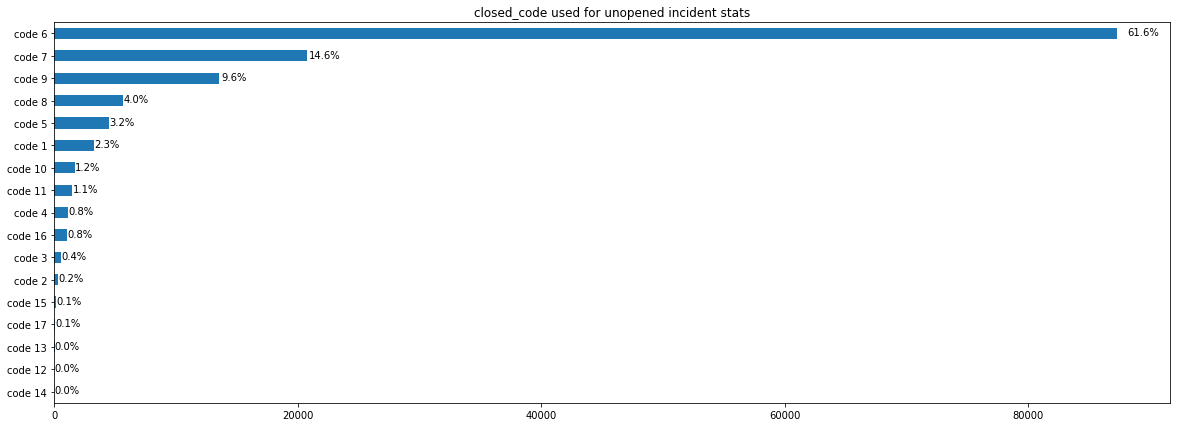

code 6     61.596013
code 7     14.632476
code 9      9.572411
code 8      3.985093
code 5      3.154336
code 1      2.302404
code 10     1.184376
code 11     1.053798
code 4      0.803936
code 16     0.770056
code 3      0.429142
code 2      0.246333
code 15     0.129166
code 17     0.081170
code 13     0.041644
code 12     0.009176
code 14     0.008470
Name: closed_code, dtype: float64

In [256]:
# Checking different types of closed codes
cloc=data1.closed_code.value_counts().sort_values(ascending=True).plot(kind="barh", figsize=(20,7), title="closed_code used for unopened incident stats")

total = len(data1['closed_code'])
for p in cloc.patches:
        percentage = '{:.1f}%'.format(100* p.get_width()/total)
        x = p.get_x() + p.get_width()*1.01
        y = p.get_y() + p.get_height()/3
        cloc.annotate(percentage, (x, y))

plt.show()

data1['closed_code'].value_counts()/len(data1['closed_code'])*100

**Inference:**
    `Code 6`, `Code 7` and `Code 9` seem to have the highest reasons as closed codes

In [257]:
# lets check what types of incidents were reopened
data_closed_reopen = data_closed[data_closed["reopen_count"]>0]



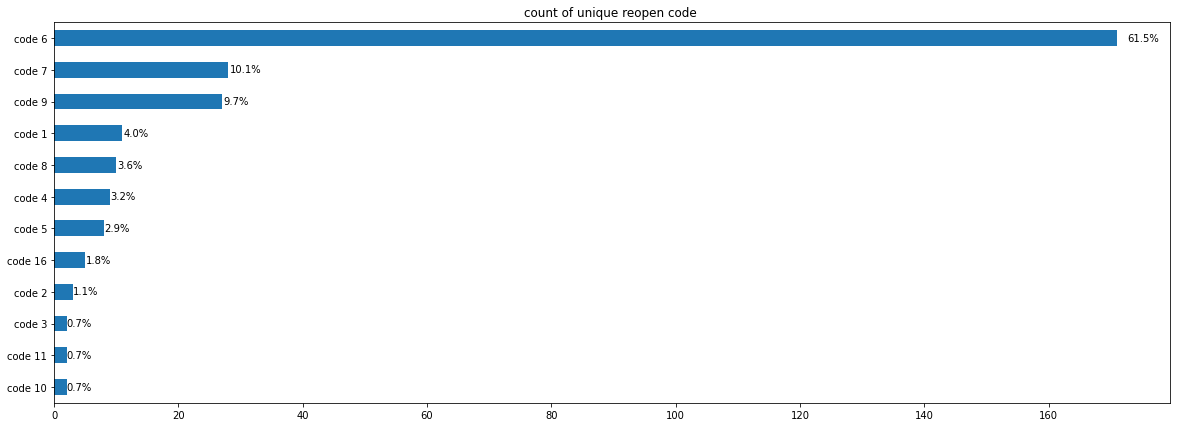

code 6     61.510791
code 7     10.071942
code 9      9.712230
code 1      3.956835
code 8      3.597122
code 4      3.237410
code 5      2.877698
code 16     1.798561
code 2      1.079137
code 10     0.719424
code 11     0.719424
code 3      0.719424
Name: closed_code, dtype: float64

In [258]:
# checking closed codes for incidents which were reopened
# Checking different types of closed codes
crcc=data_closed_reopen.closed_code.value_counts().sort_values(ascending=True).plot(kind="barh", figsize=(20,7), title="count of unique reopen code ")

total = len(data_closed_reopen.closed_code)
for p in crcc.patches:
        percentage = '{:.1f}%'.format(100* p.get_width()/total)
        x = p.get_x() + p.get_width()*1.01
        y = p.get_y() + p.get_height()/3
        crcc.annotate(percentage, (x, y))

plt.show()

data_closed_reopen.closed_code.value_counts()/len(data_closed_reopen.closed_code)*100

**Inference:**
    We can see closed codes are similar but also few closed codes which were not used earlier now incidents go closed using these closed codes.

### Checking what type of incidents are meeting SLA's


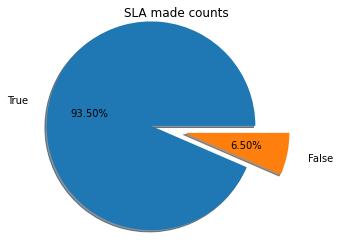

True     93.495814
False     6.504186
Name: made_sla, dtype: float64

In [259]:
ax=data1.made_sla.value_counts().plot(kind='pie', autopct='%0.2f%%',explode=[0.3,0.1],labeldistance=1.2,radius=1.2,shadow=True,title="SLA made counts")
ax.yaxis.set_visible(False)
plt.show()
data1.made_sla.value_counts()/len(data1.made_sla)*100

In [260]:
# checking what closed tickets made SLA
data_closed_sla = data_closed[data_closed["made_sla"] == 1]
data_closed_reopen_sla = data_closed_reopen[data_closed["made_sla"] == 1]



In [261]:
pd.crosstab(data_closed['made_sla'],data_closed['priority'])


priority,1 - Critical,2 - High,3 - Moderate,4 - Low
made_sla,,,,
False,265,406,8358,125
True,6,2,15166,643


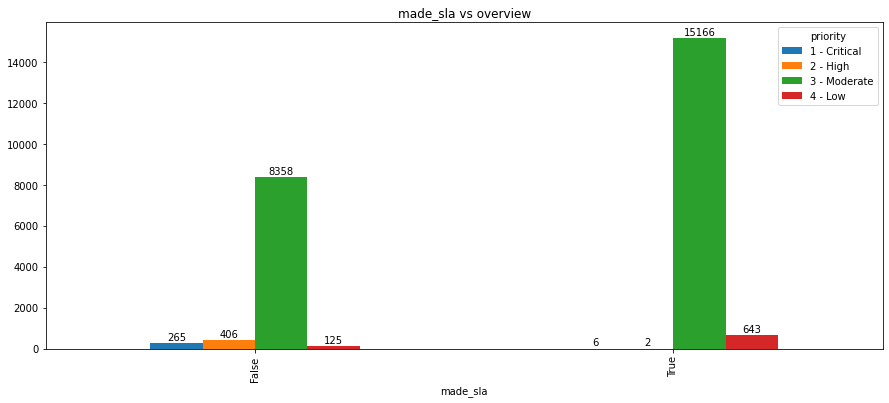

priority,1 - Critical,2 - High,3 - Moderate,4 - Low
made_sla,,,,
False,265,406,8358,125
True,6,2,15166,643


In [262]:
ctmsp=pd.crosstab(data_closed['made_sla'],data_closed['priority']).plot(kind='bar', figsize=(15,6),title="made_sla vs overview")

for p in ctmsp.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ctmsp.annotate(f'{height:1}', (x + width/2, y + height+150), ha='center')
plt.show()
pd.crosstab(data_closed['made_sla'],data_closed['priority'])

In [263]:
pd.crosstab(data_closed_reopen['made_sla'],data_closed_reopen['priority'])



priority,2 - High,3 - Moderate,4 - Low
made_sla,,,
False,5,204,1
True,0,67,1


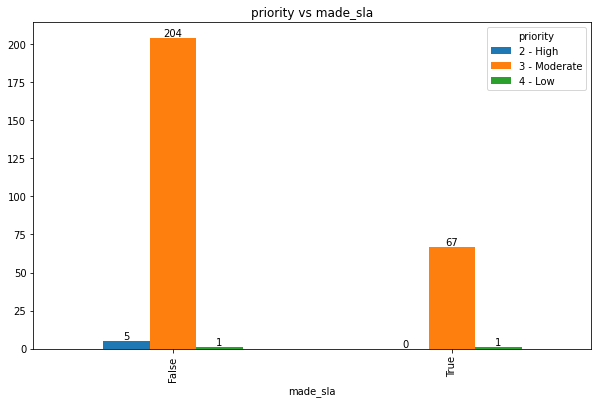

priority,2 - High,3 - Moderate,4 - Low
made_sla,,,
False,5,204,1
True,0,67,1


In [264]:
ctmscrp=pd.crosstab(data_closed_reopen['made_sla'],data_closed_reopen['priority']).plot(kind='bar',figsize=(10,6), title='priority vs made_sla')
for p in ctmscrp.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ctmscrp.annotate(f'{height:1}', (x + width/2, y + height+1), ha='center')
plt.show()
pd.crosstab(data_closed_reopen['made_sla'],data_closed_reopen['priority'])

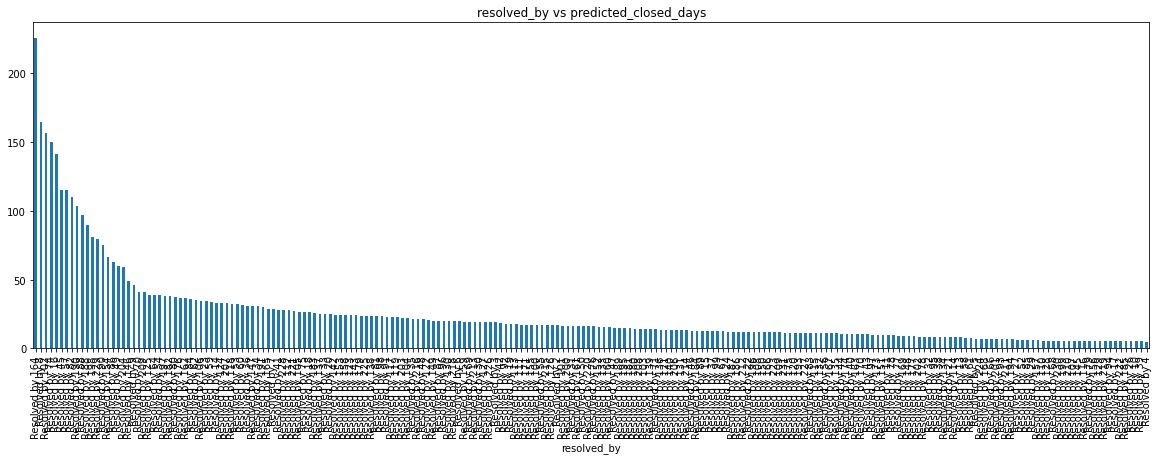

In [265]:
data1.groupby('resolved_by').mean()['predicted_closed_days'].sort_values(ascending=False).plot(kind='bar', title='resolved_by vs predicted_closed_days', figsize=(20,6))

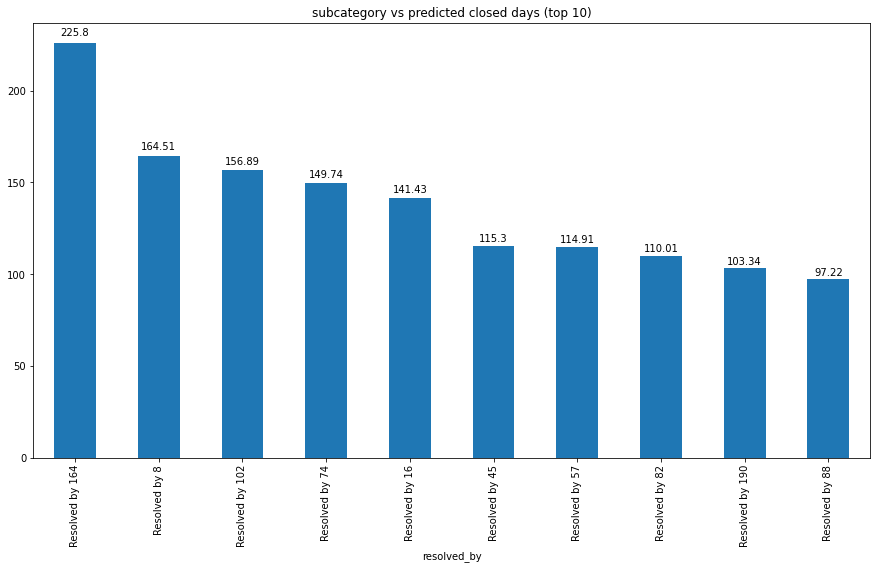

resolved_by
Resolved by 164    225.796814
Resolved by 8      164.512500
Resolved by 102    156.894838
Resolved by 74     149.736806
Resolved by 16     141.427315
Resolved by 45     115.303034
Resolved by 57     114.909946
Resolved by 82     110.005295
Resolved by 190    103.340081
Resolved by 88      97.217728
Name: predicted_closed_days, dtype: float64

In [266]:
# top 10
top10rpcd=round(data1.groupby('resolved_by').mean()['predicted_closed_days'].sort_values(ascending=False).head(10),2).plot(kind='bar', title="subcategory vs predicted closed days (top 10)", figsize=(15,8))

for p in top10rpcd.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    top10rpcd.annotate(f'{height:1}', (x + width/2, y + height*1.02), ha='center')
plt.show()
data1.groupby('resolved_by').mean()['predicted_closed_days'].sort_values(ascending=False).head(10)


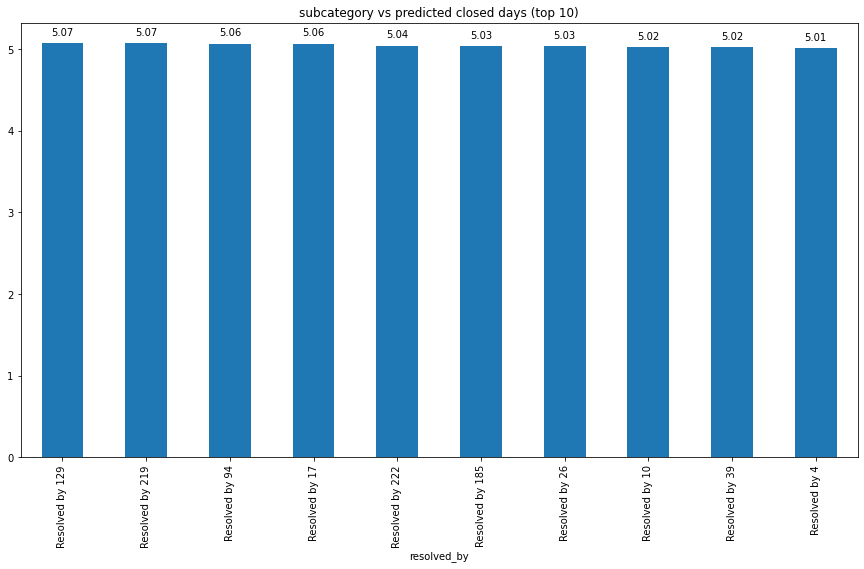

resolved_by
Resolved by 129    5.070833
Resolved by 219    5.070833
Resolved by 94     5.057799
Resolved by 17     5.056944
Resolved by 222    5.040278
Resolved by 185    5.029861
Resolved by 26     5.026587
Resolved by 10     5.021389
Resolved by 39     5.018056
Resolved by 4      5.007639
Name: predicted_closed_days, dtype: float64

In [267]:
# bottom 10
# top 10
bot10rpcd=round(data1.groupby('resolved_by').mean()['predicted_closed_days'].sort_values(ascending=False).tail(10),2).plot(kind='bar', title="subcategory vs predicted closed days (top 10)", figsize=(15,8))

for p in bot10rpcd.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    bot10rpcd.annotate(f'{height:1}', (x + width/2, y + height*1.02), ha='center')
plt.show()
data1.groupby('resolved_by').mean()['predicted_closed_days'].sort_values(ascending=False).tail(10)



**Inference:**
    We can see that few resolved by id like 164 takes too long to close case like 245 days whereas most of them have average of 5 days approximately.

### Checking if any month had more number of incidents

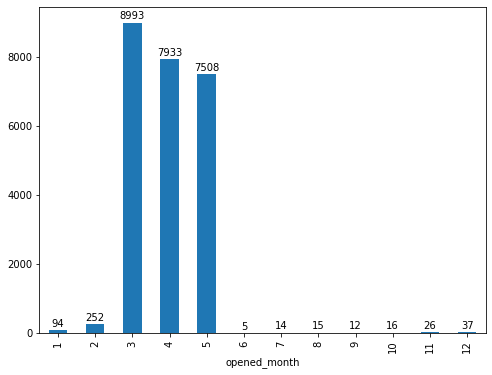

opened_month
1       94
2      252
3     8993
4     7933
5     7508
6        5
7       14
8       15
9       12
10      16
11      26
12      37
Name: number, dtype: int64

In [268]:
opnu=data1.groupby(['opened_month'])['number'].nunique().plot(kind='bar',figsize=(8,6))

for p in opnu.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    opnu.annotate(f'{height:1}', (x + width/2, y + height+100), ha='center')
plt.show()
data1.groupby(['opened_month'])['number'].nunique()

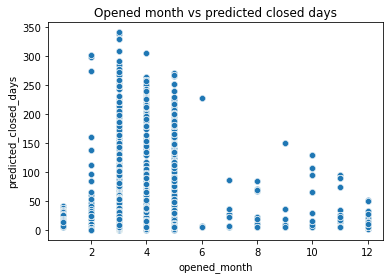

In [269]:
plt.title("Opened month vs predicted closed days")
sns.scatterplot(data1.opened_month, data1.predicted_closed_days)
plt.show()

**Inference:**
    - We can see have majority of incidents opened in the month of march-may i.e 1st half of the year . also we can see took longer time to close in initial half of year and later part we have lesser data points which took lesser time to be closed and also made SLA.

### checking if priority vs numer of days it took to close

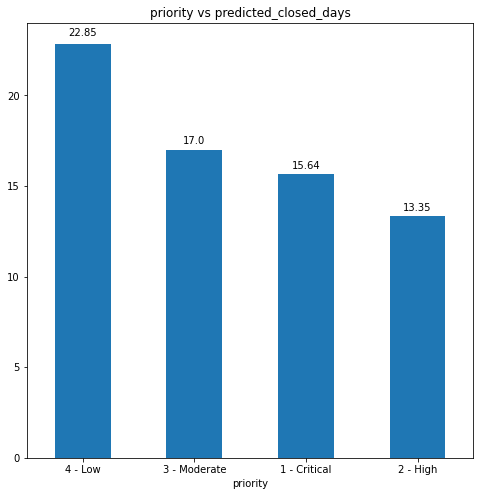

priority
4 - Low         22.852305
3 - Moderate    16.998508
1 - Critical    15.643381
2 - High        13.348383
Name: predicted_closed_days, dtype: float64

In [270]:
ppcd=round(data1.groupby('priority')['predicted_closed_days'].mean().sort_values(ascending=False),2).plot(kind='bar',figsize=(8,8), rot=0,title="priority vs predicted_closed_days")

for p in ppcd.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ppcd.annotate(f'{height:1}', (x + width/2, y + height*1.02), ha='center')
plt.show()
data1.groupby('priority')['predicted_closed_days'].mean().sort_values(ascending=False)

**Inference:**
    We can see highest priority incidents have least time taken to close days, and max number days for low priority.

### checking if impact vs numer of days it took to close

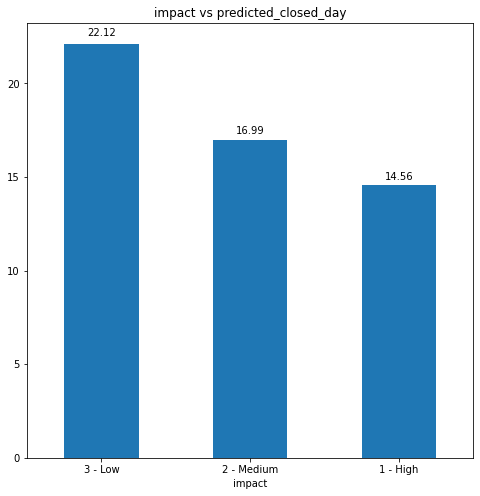

impact
3 - Low       22.122909
2 - Medium    16.985679
1 - High      14.557757
Name: predicted_closed_days, dtype: float64

In [271]:
ipcd=round(data1.groupby('impact')['predicted_closed_days'].mean().sort_values(ascending=False),2).plot(kind='bar',rot=0,figsize=(8,8), title='impact vs predicted_closed_day')
for p in ipcd.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ipcd.annotate(f'{height:1}', (x + width/2, y + height*1.02), ha='center')
plt.show()
data1.groupby('impact')['predicted_closed_days'].mean().sort_values(ascending=False)

**Inference:**
    We can see highest impact incidents have least time taken to close days, and max number days for low priority.

### Checking if SLA_Made vs 

In [272]:
pd.crosstab(data1.made_sla, data1.incident_state)

incident_state,-100,Active,Awaiting Evidence,Awaiting Problem,Awaiting User Info,Awaiting Vendor,Closed,New,Resolved
made_sla,,,,,,,,,
False,0,28,0,1,20,2,9154,0,10
True,5,38684,38,460,14621,705,15817,36392,25741


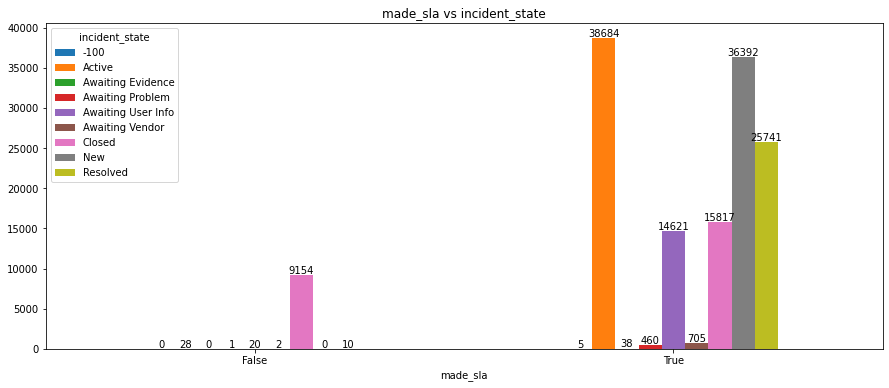

incident_state,-100,Active,Awaiting Evidence,Awaiting Problem,Awaiting User Info,Awaiting Vendor,Closed,New,Resolved
made_sla,,,,,,,,,
False,0,28,0,1,20,2,9154,0,10
True,5,38684,38,460,14621,705,15817,36392,25741


In [273]:
ctslais=pd.crosstab(data1.made_sla, data1.incident_state).plot(kind='bar', figsize=(15,6), rot=0,title='made_sla vs incident_state')

for p in ctslais.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ctslais.annotate(f'{height:1}', (x + width/2, y + height+200), ha='center')
plt.show()
pd.crosstab(data1.made_sla, data1.incident_state)

In [274]:
data1.head(2)

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,sys_created_by,sys_created_at,sys_updated_by,sys_updated_at,contact_type,location,category,subcategory,u_symptom,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,closed_code,resolved_by,resolved_at,closed_at,predicted_closed_days,days_took_to_sys_created,days_took_to_sys_updated,opened_month,opened_day,opened_hour,opened_minute,sys_updated_month,sys_updated_day,sys_updated_hour,sys_updated_minute,sys_created_month,sys_created_day,sys_created_hour,sys_created_minute
0,INC0000045,New,True,0.0,0,0.000000,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,Created by 6,2016-02-29 01:23:00,Updated by 21,2016-02-29 01:23:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,2 - Medium,2 - Medium,3 - Moderate,Group 56,Resolver 17,True,False,Do Not Notify,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00,5.447222,0.004861,0.0000,2,29,1,16,2,29,1,23,2,29,1,23
1,INC0000045,Resolved,True,0.0,0,1.414214,True,Caller 2403,Opened by 8,2016-02-29 01:16:00,Created by 6,2016-02-29 01:23:00,Updated by 642,2016-02-29 08:53:00,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,2 - Medium,2 - Medium,3 - Moderate,Group 56,Resolver 17,True,False,Do Not Notify,code 5,Resolved by 149,2016-02-29 11:29:00,2016-03-05 12:00:00,5.447222,0.004861,0.3125,2,29,1,16,2,29,8,53,2,29,1,23


## Preparing data for modelling:

In [275]:
data1.columns

Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by',
       'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory',
       'u_symptom', 'impact', 'urgency', 'priority', 'assignment_group',
       'assigned_to', 'knowledge', 'u_priority_confirmation', 'notify',
       'closed_code', 'resolved_by', 'resolved_at', 'closed_at',
       'predicted_closed_days', 'days_took_to_sys_created',
       'days_took_to_sys_updated', 'opened_month', 'opened_day', 'opened_hour',
       'opened_minute', 'sys_updated_month', 'sys_updated_day',
       'sys_updated_hour', 'sys_updated_minute', 'sys_created_month',
       'sys_created_day', 'sys_created_hour', 'sys_created_minute'],
      dtype='object')

In [276]:
data1.shape

(141678, 46)

In [277]:
# filtering data for unresolved and not closed incidents

data2 = data1[(data1.incident_state!='Resolved')&(data1.incident_state!='Closed')]
data2 = data2.drop(['opened_at', 'sys_updated_at', 'resolved_at', 'closed_code', 'closed_at', 'sys_created_at','caller_id'], axis=1)

data2 = data2.reset_index(drop=True)

### Seperating cateorical and numerical features

In [278]:
feat_cat = data2.select_dtypes(['object','bool'])
feat_num = data2.select_dtypes(np.number)


In [279]:
#Categorical features
feat_cat.head(2)


,number,incident_state,active,made_sla,opened_by,sys_created_by,sys_updated_by,contact_type,location,category,subcategory,u_symptom,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,resolved_by
0,INC0000045,New,True,True,Opened by 8,Created by 6,Updated by 21,Phone,Location 143,Category 55,Subcategory 170,Symptom 72,2 - Medium,2 - Medium,3 - Moderate,Group 56,Resolver 17,True,False,Do Not Notify,Resolved by 149
1,INC0000047,New,True,True,Opened by 397,Created by 171,Updated by 746,Phone,Location 165,Category 40,Subcategory 215,Symptom 471,2 - Medium,2 - Medium,3 - Moderate,Group 70,Resolver 89,True,False,Do Not Notify,Resolved by 81


In [280]:
#Numerical features
feat_num.head(2)

,reassignment_count,reopen_count,sys_mod_count,predicted_closed_days,days_took_to_sys_created,days_took_to_sys_updated,opened_month,opened_day,opened_hour,opened_minute,sys_updated_month,sys_updated_day,sys_updated_hour,sys_updated_minute,sys_created_month,sys_created_day,sys_created_hour,sys_created_minute
0,0.0,0,0.0,5.447222,0.004861,0.0,2,29,1,16,2,29,1,23,2,29,1,23
1,0.0,0,0.0,6.222222,0.011806,0.0,2,29,4,40,2,29,4,57,2,29,4,57


In [281]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90956 entries, 0 to 90955
Data columns (total 39 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   number                    90956 non-null  object 
 1   incident_state            90956 non-null  object 
 2   active                    90956 non-null  bool   
 3   reassignment_count        90956 non-null  float64
 4   reopen_count              90956 non-null  int64  
 5   sys_mod_count             90956 non-null  float64
 6   made_sla                  90956 non-null  bool   
 7   opened_by                 90956 non-null  object 
 8   sys_created_by            90956 non-null  object 
 9   sys_updated_by            90956 non-null  object 
 10  contact_type              90956 non-null  object 
 11  location                  90956 non-null  object 
 12  category                  90956 non-null  object 
 13  subcategory               90956 non-null  object 
 14  u_symp

In [282]:
# applying label encoding to ordinal data
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
feat_cat_encoded= feat_cat.apply(le.fit_transform)


In [283]:
#Final data set with transformed numerical columns and encoded categorical columns
data = pd.concat([feat_num,feat_cat_encoded],axis=1)
data.head()

,reassignment_count,reopen_count,sys_mod_count,predicted_closed_days,days_took_to_sys_created,days_took_to_sys_updated,opened_month,opened_day,opened_hour,opened_minute,sys_updated_month,sys_updated_day,sys_updated_hour,sys_updated_minute,sys_created_month,sys_created_day,sys_created_hour,sys_created_minute,number,incident_state,active,made_sla,opened_by,sys_created_by,sys_updated_by,contact_type,location,category,subcategory,u_symptom,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,resolved_by
0,0.0,0,0.000000,5.447222,0.004861,0.000000,2,29,1,16,2,29,1,23,2,29,1,23,0,6,0,1,199,151,95,2,42,45,68,499,1,1,2,47,72,1,0,0,51
1,0.0,0,0.000000,6.222222,0.011806,0.000000,2,29,4,40,2,29,4,57,2,29,4,57,1,6,0,1,120,58,548,2,61,29,111,351,1,1,2,63,220,1,0,0,196
2,1.0,0,1.000000,6.222222,0.011806,0.022917,2,29,4,40,2,29,5,30,2,29,4,57,1,1,0,1,120,58,95,2,61,29,111,351,1,1,2,15,164,1,0,0,196
3,1.0,0,1.414214,6.222222,0.011806,0.025000,2,29,4,40,2,29,5,33,2,29,4,57,1,1,0,1,120,58,95,2,61,29,111,351,1,1,2,15,164,1,0,0,196
4,1.0,0,1.732051,6.222222,0.011806,0.273611,2,29,4,40,2,29,11,31,2,29,4,57,1,1,0,1,120,58,596,2,61,29,111,351,1,1,2,15,164,1,0,0,196


In [284]:

X=data.drop(["predicted_closed_days"],axis=1)
y=data["predicted_closed_days"]

In [285]:
# scaling the data
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
data_scaled = ss.fit_transform(X)

data_scaled = pd.DataFrame(data_scaled, columns=X.columns)
data_scaled.head()

,reassignment_count,reopen_count,sys_mod_count,days_took_to_sys_created,days_took_to_sys_updated,opened_month,opened_day,opened_hour,opened_minute,sys_updated_month,sys_updated_day,sys_updated_hour,sys_updated_minute,sys_created_month,sys_created_day,sys_created_hour,sys_created_minute,number,incident_state,active,made_sla,opened_by,sys_created_by,sys_updated_by,contact_type,location,category,subcategory,u_symptom,impact,urgency,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,resolved_by
0,-0.936872,-0.112487,-1.182618,-0.089414,-0.294264,-1.862223,1.610383,-2.753916,-0.780255,-1.801391,1.583232,-2.829168,-0.390680,-1.859142,1.634701,-2.775250,-0.392518,-1.529484,1.083193,0.0,0.023686,1.777451,1.251550,-1.207674,-0.064681,-0.862678,1.098438,-0.599141,1.517636,0.005372,0.028698,0.089545,0.147366,-0.547887,2.007743,-0.148558,-0.022738,-0.655482
1,-0.936872,-0.112487,-1.182618,-0.084235,-0.294264,-1.862223,1.610383,-1.995350,0.610654,-1.801391,1.583232,-2.082425,1.573180,-1.859142,1.634701,-2.016262,1.565202,-1.529336,1.083193,0.0,0.023686,0.555439,-0.232126,0.709954,-0.064681,-0.565844,-0.039909,0.074229,0.222351,0.005372,0.028698,0.089545,0.865267,2.117173,2.007743,-0.148558,-0.022738,1.731838
2,0.320041,-0.112487,-0.447352,-0.084235,-0.292741,-1.862223,1.610383,-1.995350,0.610654,-1.801391,1.583232,-1.833510,0.013644,-1.859142,1.634701,-2.016262,1.565202,-1.529336,-1.105096,0.0,0.023686,0.555439,-0.232126,-1.207674,-0.064681,-0.565844,-0.039909,0.074229,0.222351,0.005372,0.028698,0.089545,-1.288435,1.108772,2.007743,-0.148558,-0.022738,1.731838
3,0.320041,-0.112487,-0.142795,-0.084235,-0.292603,-1.862223,1.610383,-1.995350,0.610654,-1.801391,1.583232,-1.833510,0.186926,-1.859142,1.634701,-2.016262,1.565202,-1.529336,-1.105096,0.0,0.023686,0.555439,-0.232126,-1.207674,-0.064681,-0.565844,-0.039909,0.074229,0.222351,0.005372,0.028698,0.089545,-1.288435,1.108772,2.007743,-0.148558,-0.022738,1.731838
4,0.320041,-0.112487,0.090900,-0.084235,-0.276088,-1.862223,1.610383,-1.995350,0.610654,-1.801391,1.583232,-0.340023,0.071404,-1.859142,1.634701,-2.016262,1.565202,-1.529336,-1.105096,0.0,0.023686,0.555439,-0.232126,0.913146,-0.064681,-0.565844,-0.039909,0.074229,0.222351,0.005372,0.028698,0.089545,-1.288435,1.108772,2.007743,-0.148558,-0.022738,1.731838


In [286]:
# Selecting columns based on purpose
data_final=data_scaled.drop(['days_took_to_sys_created','days_took_to_sys_updated',
       'sys_updated_month', 'sys_updated_day',
       'sys_updated_hour', 'sys_updated_minute', 'made_sla','notify','resolved_by',
       'sys_updated_by','active','number','impact','urgency','contact_type'],axis=1)


In [287]:
X=data_final.copy()
y

0        5.447222
1        6.222222
2        6.222222
3        6.222222
4        6.222222
           ...   
90951    1.950000
90952    0.030556
90953    0.030556
90954    0.097917
90955    0.097917
Name: predicted_closed_days, Length: 90956, dtype: float64

In [288]:
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm

X_constant=sm.add_constant(X)

ols = sm.OLS(y, X_constant)
ols_mod = ols.fit()
ols_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     predicted_closed_days   R-squared:                       0.222
Model:                               OLS   Adj. R-squared:                  0.222
Method:                    Least Squares   F-statistic:                     1127.
Date:                   Mon, 09 Nov 2020   Prob (F-statistic):               0.00
Time:                           12:55:26   Log-Likelihood:            -4.2478e+05
No. Observations:                  90956   AIC:                         8.496e+05
Df Residuals:                      90932   BIC:                         8.498e+05
Df Model:                             23                                         
Covariance Type:               nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      19.1612      0.086    223.763      0.000      18.993      19.329
reassignment_count         -8.6255      0.123    -70.091      0.000      -8.867      -8.384
reopen_count               -1.8429      0.113    -16.286      0.000      -2.065      -1.621
sys_mod_count              18.5576      0.128    144.586      0.000      18.306      18.809
opened_month              -11.6840      1.984     -5.890      0.000     -15.572      -7.796
opened_day                 -4.1560      0.746     -5.572      0.000      -5.618      -2.694
opened_hour                 0.1767      0.382      0.463      0.644      -0.572       0.925
opened_minute              -0.5454      0.107     -5.115      0.000      -0.754      -0.336
sys_created_month          11.5465      1.991      5.799      0.000       7.644      15.449
sys_created_day             3.7043      0.743      4.984      0.000       2.247       5.161
sys_created_hour            0.3381      0.382      0.886      0.376      -0.410       1.086
sys_created_minute          0.5226      0.107      4.880      0.000       0.313       0.732
incident_state              3.0127      0.090     33.409      0.000       2.836       3.189
opened_by                   0.0404      0.090      0.452      0.651      -0.135       0.216
sys_created_by             -0.3877      0.090     -4.318      0.000      -0.564      -0.212
location                    0.1299      0.086      1.505      0.132      -0.039       0.299
category                   -0.3670      0.087     -4.234      0.000      -0.537      -0.197
subcategory                -0.6131      0.087     -7.049      0.000      -0.784      -0.443
u_symptom                   0.1969      0.086      2.283      0.022       0.028       0.366
priority                    1.7803      0.089     20.093      0.000       1.607       1.954
assignment_group            0.8113      0.089      9.128      0.000       0.637       0.986
assigned_to                 1.7923      0.089     20.237      0.000       1.619       1.966
knowledge                   2.1009      0.112     18.716      0.000       1.881       2.321
u_priority_confirmation     0.3066      0.114      2.678      0.007       0.082       0.531
==============================================================================
Omnibus:                    88040.544   Durbin-Watson:                   0.446
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4377887.707
Skew:                           4.784   Prob(JB):                         0.00
Kurtosis:                      35.613   Cond. No.                         56.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly 

In [289]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['columns']=X.columns.tolist()
vif['vif']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
# pd.DataFrame({"vif":vif[1:]},index=X.columns).sort_values(ascending=False)


In [290]:
vif.sort_values(by='vif',ascending=False)

,columns,vif
7,sys_created_month,540.692235
3,opened_month,536.624628
4,opened_day,75.871415
8,sys_created_day,75.343216
5,opened_hour,19.879972
9,sys_created_hour,19.862032
2,sys_mod_count,2.246579
0,reassignment_count,2.065285
22,u_priority_confirmation,1.787170
1,reopen_count,1.746111


In [291]:
significant_features = ols_mod.pvalues[ols_mod.pvalues < 0.05].index
insignificant_features = ols_mod.pvalues[ols_mod.pvalues > 0.05].index.tolist()

In [292]:
insignificant_features

['opened_hour', 'sys_created_hour', 'opened_by', 'location']

In [293]:
inp2=X.drop(insignificant_features,axis=1)

In [294]:
len(inp2.columns)

19

In [295]:
# checking model after using columns with signifact features
X_constant=sm.add_constant(inp2)

ols = sm.OLS(y, X_constant)
ols_mod3 = ols.fit()
ols_mod3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     predicted_closed_days   R-squared:                       0.221
Model:                               OLS   Adj. R-squared:                  0.221
Method:                    Least Squares   F-statistic:                     1362.
Date:                   Mon, 09 Nov 2020   Prob (F-statistic):               0.00
Time:                           12:56:30   Log-Likelihood:            -4.2480e+05
No. Observations:                  90956   AIC:                         8.496e+05
Df Residuals:                      90936   BIC:                         8.498e+05
Df Model:                             19                                         
Covariance Type:               nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      19.1612      0.086    223.720      0.000      18.993      19.329
reassignment_count         -8.6137      0.123    -70.011      0.000      -8.855      -8.373
reopen_count               -1.8387      0.113    -16.253      0.000      -2.060      -1.617
sys_mod_count              18.5559      0.128    144.600      0.000      18.304      18.807
opened_month              -11.5713      1.977     -5.852      0.000     -15.447      -7.696
opened_day                 -4.1470      0.745     -5.564      0.000      -5.608      -2.686
opened_minute              -0.5567      0.104     -5.357      0.000      -0.760      -0.353
sys_created_month          11.4217      1.985      5.755      0.000       7.532      15.311
sys_created_day             3.6770      0.743      4.950      0.000       2.221       5.133
sys_created_minute          0.5083      0.104      4.890      0.000       0.305       0.712
incident_state              3.0308      0.090     33.657      0.000       2.854       3.207
sys_created_by             -0.3910      0.088     -4.458      0.000      -0.563      -0.219
category                   -0.3698      0.087     -4.271      0.000      -0.540      -0.200
subcategory                -0.5941      0.087     -6.839      0.000      -0.764      -0.424
u_symptom                   0.2057      0.086      2.386      0.017       0.037       0.375
priority                    1.7956      0.088     20.344      0.000       1.623       1.969
assignment_group            0.8004      0.089      9.012      0.000       0.626       0.975
assigned_to                 1.7811      0.089     20.114      0.000       1.608       1.955
knowledge                   2.1132      0.112     18.927      0.000       1.894       2.332
u_priority_confirmation     0.3118      0.114      2.724      0.006       0.087       0.536
==============================================================================
Omnibus:                    88021.481   Durbin-Watson:                   0.446
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4373076.502
Skew:                           4.783   Prob(JB):                         0.00
Kurtosis:                      35.594   Cond. No.                         55.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [296]:
from sklearn.ensemble import RandomForestRegressor

rfe = RandomForestRegressor(random_state=4)
rfe.fit(inp2, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=4, verbose=0, warm_start=False)

<BarContainer object of 19 artists>

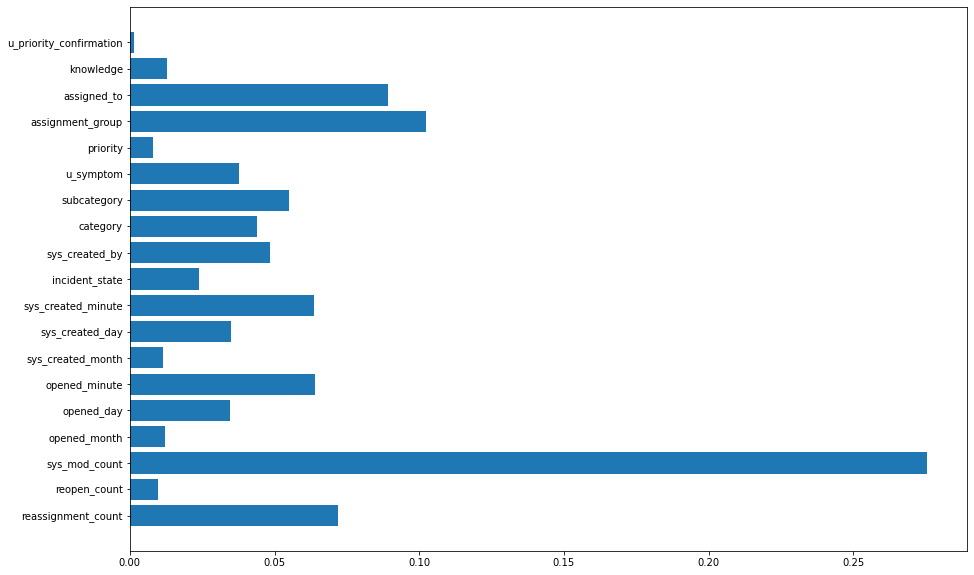

In [297]:
plt.figure(figsize=(15,10))
plt.barh(inp2.columns,rfe.feature_importances_)

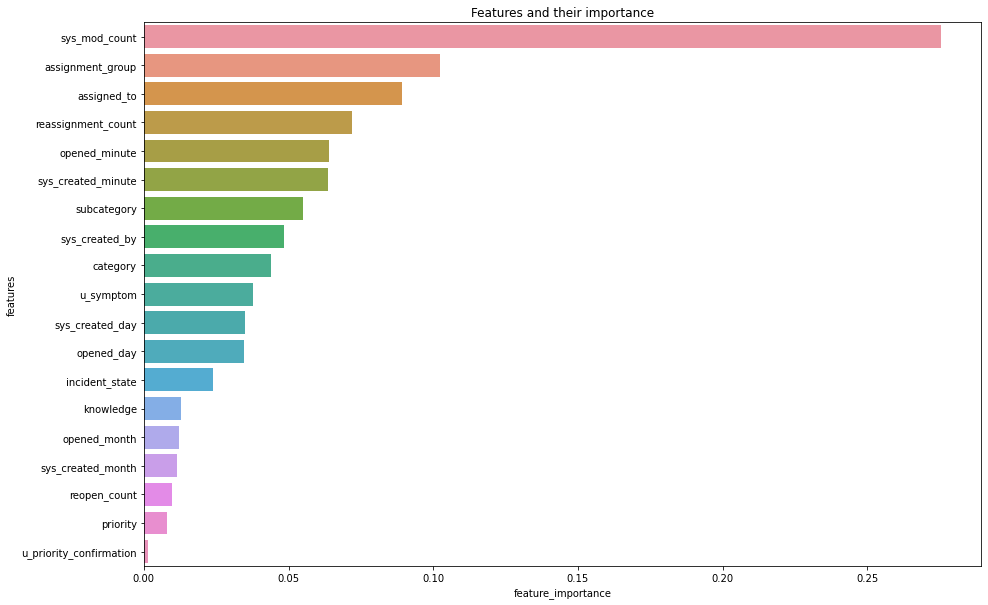

In [298]:
feat_imp = pd.DataFrame({'features':inp2.columns.tolist(),
             'feature_importance':rfe.feature_importances_}).sort_values(by='feature_importance', ascending=False)

plt.figure(figsize=(15,10))
sns.barplot( 'feature_importance', 'features', data=feat_imp)
plt.title("Features and their importance")

plt.show()

## Evaluting the models

## Base model Random forest

In [299]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(inp2, y, test_size=0.3, random_state=0)

In [300]:
# build and train the model
rfe = RandomForestRegressor(random_state=0)
rfe.fit(xtrain, ytrain)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [301]:
#predict values
ypred_train = rfe.predict(xtrain)
ypred_test = rfe.predict(xtest)

#evaluating the metrics
from sklearn.metrics import mean_squared_error, r2_score

rmse_train = np.sqrt(mean_squared_error(ytrain, ypred_train))
rmse_test = np.sqrt(mean_squared_error(ytest, ypred_test))

rsquared_train = r2_score(ytrain, ypred_train)
rsquared_test = r2_score(ytest, ypred_test)

print(f"rsquared  - (Train) : {rsquared_train}")
print(f"root mean squared error - (Train) : {rmse_train}")


print(f"rsquared  - (Test) : {rsquared_test}")
print(f"root mean squared error - (Test) : {rmse_test}")

rsquared  - (Train) : 0.9626413696409397
root mean squared error - (Train) : 5.645439754326464
rsquared  - (Test) : 0.747917025602061
root mean squared error - (Test) : 14.771806116352911


## RF with hyperparam tuning

In [307]:
from sklearn.ensemble import RandomForestRegressor

rfe = RandomForestRegressor(bootstrap=True, 
                      max_depth=70, max_features='auto',
                      min_samples_leaf=4,
                      min_samples_split=10,
                      n_estimators=250,
                      random_state=4, verbose=1, warm_start=False)
rfe.fit(xtrain, ytrain)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  2.0min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=70, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=250, n_jobs=None, oob_score=False,
                      random_state=4, verbose=1, warm_start=False)

In [308]:
#predict values
ypred_train = rfe.predict(xtrain)
ypred_test = rfe.predict(xtest)

#evaluating the metrics
from sklearn.metrics import mean_squared_error, r2_score

rmse_train = np.sqrt(mean_squared_error(ytrain, ypred_train))
rmse_test = np.sqrt(mean_squared_error(ytest, ypred_test))

rsquared_train = r2_score(ytrain, ypred_train)
rsquared_test = r2_score(ytest, ypred_test)

print(f"rsquared  - (Train) : {rsquared_train}")
print(f"root mean squared error - (Train) : {rmse_train}")


print(f"rsquared  - (Test) : {rsquared_test}")
print(f"root mean squared error - (Test) : {rmse_test}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


rsquared  - (Train) : 0.7989335764943619
root mean squared error - (Train) : 13.097007636688202
rsquared  - (Test) : 0.6640848549261873
root mean squared error - (Test) : 17.052051434813507


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.8s finished


In [309]:
from sklearn.ensemble import RandomForestRegressor

rfe = RandomForestRegressor(bootstrap=True, 
                      max_depth=80, max_features='auto',
                      min_samples_leaf=10,
                      min_samples_split=20,
                      n_estimators=250,
                      random_state=4, verbose=1, warm_start=False)
rfe.fit(xtrain, ytrain)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.8min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=80, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      n_estimators=250, n_jobs=None, oob_score=False,
                      random_state=4, verbose=1, warm_start=False)

In [310]:
#predict values
ypred_train = rfe.predict(xtrain)
ypred_test = rfe.predict(xtest)

#evaluating the metrics
from sklearn.metrics import mean_squared_error, r2_score

rmse_train = np.sqrt(mean_squared_error(ytrain, ypred_train))
rmse_test = np.sqrt(mean_squared_error(ytest, ypred_test))

rsquared_train = r2_score(ytrain, ypred_train)
rsquared_test = r2_score(ytest, ypred_test)

print(f"rsquared  - (Train) : {rsquared
                               _train}")
print(f"root mean squared error - (Train) : {rmse_train}")


print(f"rsquared  - (Test) : {rsquared_test}")
print(f"root mean squared error - (Test) : {rmse_test}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    3.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


rsquared  - (Train) : 0.6828031564053649
root mean squared error - (Train) : 16.450031457776564
rsquared  - (Test) : 0.6006741147942591
root mean squared error - (Test) : 18.591976982586175


[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    1.6s finished


## Gradient Boosting

In [311]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(inp2, y, test_size=0.3, random_state=0)

In [312]:
from sklearn.ensemble import GradientBoostingRegressor

gb=GradientBoostingRegressor(n_estimators=1000)
mod=gb.fit(xtrain,ytrain)

In [313]:
from sklearn.metrics import r2_score,mean_squared_error
r2_train=r2_score(ytrain,mod.predict(xtrain))
r2_test=r2_score(ytest,mod.predict(xtest))

mse_train=mean_squared_error(ytrain,mod.predict(xtrain))
mse_test=mean_squared_error(ytest,mod.predict(xtest))

rmse_train=np.sqrt(mse_train)
rmse_test=np.sqrt(mse_test)

print('r2_train : \n',r2_train,'\n r2_test : \n',r2_test,'\n mse_train : \n',mse_train,'\n mse_test : \n',mse_test,'\n rmse_train : \n',rmse_train,'\n rmse_test \n',rmse_test)

r2_train : 
 0.6644140690875802 
 r2_test : 
 0.6302907048353859 
 mse_train : 
 286.2914339223774 
 mse_test : 
 320.0251079091579 
 rmse_train : 
 16.920148755917527 
 rmse_test 
 17.889245593628534


In [314]:
from sklearn.linear_model import SGDRegressor

In [315]:
n_iter=1000
clf_ = SGDRegressor(max_iter=n_iter)
clf_.fit(xtrain, ytrain)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [317]:
ypred_train = clf_.predict(xtrain)
ypred_test = clf_.predict(xtest)

#evaluating the metrics
from sklearn.metrics import mean_squared_error, r2_score

rmse_train = np.sqrt(mean_squared_error(ytrain, ypred_train))
rmse_test = np.sqrt(mean_squared_error(ytest, ypred_test))

rsquared_train = r2_score(ytrain, ypred_train)
rsquared_test = r2_score(ytest, ypred_test)

print(f"rsquared  - (Train) : {rsquared_train}")
print(f"root mean squared error - (Train) : {rmse_train}")


print(f"rsquared  - (Test) : {rsquared_test}")
print(f"root mean squared error - (Test) : {rmse_test}")

rsquared  - (Train) : 0.21573370823207894
root mean squared error - (Train) : 25.866286218690572
rsquared  - (Test) : 0.228584675407575
root mean squared error - (Test) : 25.840801059512827


## Model building with some other featues

In [318]:
data_final=data_scaled.drop(['days_took_to_sys_created','days_took_to_sys_updated', 'made_sla','notify','resolved_by','sys_updated_by','active','number','impact','urgency','contact_type'],axis=1)


In [319]:
X = data_final.copy()
y=data["predicted_closed_days"]

In [320]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['columns']=X.columns.tolist()
vif['vif']=[variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif.sort_values(by='vif',ascending=False)

,columns,vif
3,opened_month,541.193835
11,sys_created_month,540.786752
4,opened_day,76.386198
12,sys_created_day,75.753196
13,sys_created_hour,19.991208
5,opened_hour,19.911955
7,sys_updated_month,7.770244
2,sys_mod_count,3.596436
8,sys_updated_day,2.516450
0,reassignment_count,2.322035


In [321]:
inp1 = X.drop(['sys_created_month','sys_created_day','sys_created_hour'],axis=1)

In [322]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['columns']=inp1.columns.tolist()
vif['vif']=[variance_inflation_factor(inp1.values,i) for i in range(inp1.shape[1])]
vif.sort_values(by='vif',ascending=False)

,columns,vif
7,sys_updated_month,7.768744
3,opened_month,7.257096
2,sys_mod_count,3.594302
4,opened_day,2.757574
8,sys_updated_day,2.467429
0,reassignment_count,2.318365
23,u_priority_confirmation,1.786962
1,reopen_count,1.753878
22,knowledge,1.714556
11,sys_created_minute,1.577163


In [323]:
X_constant=sm.add_constant(inp1)

ols = sm.OLS(y, X_constant)
ols_mod = ols.fit()
ols_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     predicted_closed_days   R-squared:                       0.346
Model:                               OLS   Adj. R-squared:                  0.346
Method:                    Least Squares   F-statistic:                     2009.
Date:                   Mon, 09 Nov 2020   Prob (F-statistic):               0.00
Time:                           13:22:49   Log-Likelihood:            -4.1684e+05
No. Observations:                  90956   AIC:                         8.337e+05
Df Residuals:                      90931   BIC:                         8.340e+05
Df Model:                             24                                         
Covariance Type:               nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      19.1612      0.078    244.171      0.000      19.007      19.315
reassignment_count         -3.4174      0.119    -28.601      0.000      -3.652      -3.183
reopen_count               -1.0046      0.104     -9.667      0.000      -1.208      -0.801
sys_mod_count               6.5892      0.149     44.289      0.000       6.298       6.881
opened_month              -25.3100      0.211   -119.724      0.000     -25.724     -24.896
opened_day                 -7.4009      0.130    -56.792      0.000      -7.656      -7.145
opened_hour                -0.0992      0.089     -1.120      0.263      -0.273       0.074
opened_minute              -0.4592      0.095     -4.813      0.000      -0.646      -0.272
sys_updated_month          28.8132      0.219    131.731      0.000      28.384      29.242
sys_updated_day             6.9268      0.123     56.193      0.000       6.685       7.168
sys_updated_hour            0.6791      0.089      7.670      0.000       0.506       0.853
sys_updated_minute          0.1934      0.083      2.334      0.020       0.031       0.356
sys_created_minute          0.4546      0.099      4.613      0.000       0.261       0.648
incident_state              1.6444      0.083     19.784      0.000       1.482       1.807
opened_by                   0.1782      0.082      2.172      0.030       0.017       0.339
sys_created_by             -0.2509      0.082     -3.051      0.002      -0.412      -0.090
location                    0.0891      0.079      1.127      0.260      -0.066       0.244
category                   -0.1096      0.079     -1.380      0.168      -0.265       0.046
subcategory                -0.4134      0.080     -5.187      0.000      -0.570      -0.257
u_symptom                  -0.0763      0.079     -0.965      0.334      -0.231       0.079
priority                    0.9919      0.081     12.183      0.000       0.832       1.151
assignment_group            0.4005      0.082      4.914      0.000       0.241       0.560
assigned_to                 1.4128      0.081     17.406      0.000       1.254       1.572
knowledge                   2.6193      0.103     25.491      0.000       2.418       2.821
u_priority_confirmation     0.0900      0.105      0.858      0.391      -0.116       0.296
==============================================================================
Omnibus:                   105775.055   Durbin-Watson:                   0.472
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10766453.076
Skew:                           6.241   Prob(JB):                         0.00
Kurtosis:                      54.818   Cond. No.                         6.57
==============================================================================


In [324]:
from sklearn.ensemble import RandomForestRegressor

rfe = RandomForestRegressor(random_state=4)
rfe.fit(inp1, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=4, verbose=0, warm_start=False)

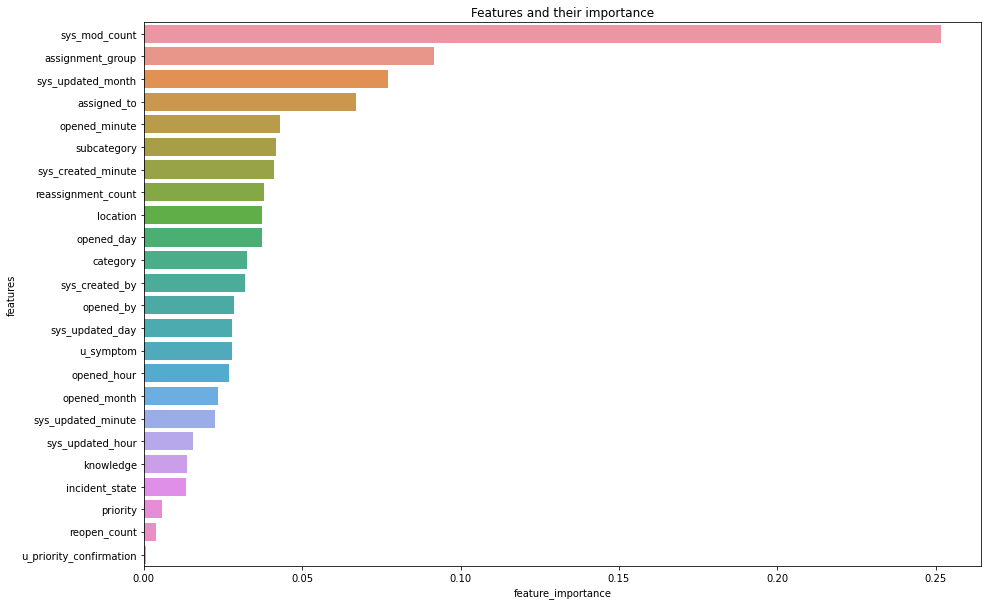

In [325]:
feat_imp = pd.DataFrame({'features':inp1.columns.tolist(),
             'feature_importance':rfe.feature_importances_}).sort_values(by='feature_importance', ascending=False)

plt.figure(figsize=(15,10))
sns.barplot( 'feature_importance', 'features', data=feat_imp)
plt.title("Features and their importance")

plt.show()

In [326]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(inp1, y, test_size=0.3, random_state=0)

In [327]:
rfe = RandomForestRegressor(random_state=0)
rfe.fit(xtrain, ytrain)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [328]:
#predict values
ypred_train = rfe.predict(xtrain)
ypred_test = rfe.predict(xtest)

#evaluating the metrics
from sklearn.metrics import mean_squared_error, r2_score

rmse_train = np.sqrt(mean_squared_error(ytrain, ypred_train))
rmse_test = np.sqrt(mean_squared_error(ytest, ypred_test))

rsquared_train = r2_score(ytrain, ypred_train)
rsquared_test = r2_score(ytest, ypred_test)

print(f"rsquared  - (Train) : {rsquared_train}")
print(f"root mean squared error - (Train) : {rmse_train}")


print(f"rsquared  - (Test) : {rsquared_test}")
print(f"root mean squared error - (Test) : {rmse_test}")

rsquared  - (Train) : 0.9620878077604128
root mean squared error - (Train) : 5.687111633722154
rsquared  - (Test) : 0.7363726273035619
root mean squared error - (Test) : 15.106264765937448


## RF with hyperparameter Tuning

In [329]:
from sklearn.ensemble import RandomForestRegressor

rfe = RandomForestRegressor(bootstrap=True, 
                      max_depth=1000, max_features='auto',
                      min_samples_leaf=10,
                      min_samples_split=20,
                      n_estimators=1000,
                      random_state=4, verbose=1, warm_start=False)
rfe.fit(xtrain, ytrain)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed: 10.3min finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=1000, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=10,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=4, verbose=1, warm_start=False)

In [330]:
#predict values
ypred_train = rfe.predict(xtrain)
ypred_test = rfe.predict(xtest)

#evaluating the metrics
from sklearn.metrics import mean_squared_error, r2_score

rmse_train = np.sqrt(mean_squared_error(ytrain, ypred_train))
rmse_test = np.sqrt(mean_squared_error(ytest, ypred_test))

rsquared_train = r2_score(ytrain, ypred_train)
rsquared_test = r2_score(ytest, ypred_test)

print(f"rsquared  - (Train) : {rsquared_train}")
print(f"root mean squared error - (Train) : {rmse_train}")


print(f"rsquared  - (Test) : {rsquared_test}")
print(f"root mean squared error - (Test) : {rmse_test}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   13.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


rsquared  - (Train) : 0.7068052582834794
root mean squared error - (Train) : 15.815407735063358
rsquared  - (Test) : 0.6173030148059215
root mean squared error - (Test) : 18.200753253178952


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    5.7s finished


## Gradient boosting


In [331]:
from sklearn.ensemble import GradientBoostingRegressor

gb=GradientBoostingRegressor(n_estimators=1000)
mod=gb.fit(xtrain,ytrain)

In [332]:
from sklearn.metrics import r2_score,mean_squared_error
r2_train=r2_score(ytrain,mod.predict(xtrain))
r2_test=r2_score(ytest,mod.predict(xtest))

mse_train=mean_squared_error(ytrain,mod.predict(xtrain))
mse_test=mean_squared_error(ytest,mod.predict(xtest))

rmse_train=np.sqrt(mse_train)
rmse_test=np.sqrt(mse_test)

print('r2_train : \n',r2_train,'\n r2_test : \n',r2_test,'\n mse_train : \n',mse_train,'\nmse_test : \n',mse_test,'\n rmse_train : \n',rmse_train,'\n rmse_test \n',rmse_test)

r2_train : 
 0.686814636015405 
 r2_test : 
 0.6503041015196314 
 mse_train : 
 267.18130493394005 
mse_test : 
 302.70125504077737 
 rmse_train : 
 16.3456815377622 
 rmse_test 
 17.39831184456634


## SGD Regressor


In [333]:
from sklearn.linear_model import SGDRegressor
n_iter=1000
clf_ = SGDRegressor(max_iter=n_iter)
clf_.fit(xtrain, ytrain)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [334]:
ypred_train = clf_.predict(xtrain)
ypred_test = clf_.predict(xtest)

#evaluating the metrics
from sklearn.metrics import mean_squared_error, r2_score

rmse_train = np.sqrt(mean_squared_error(ytrain, ypred_train))
rmse_test = np.sqrt(mean_squared_error(ytest, ypred_test))

rsquared_train = r2_score(ytrain, ypred_train)
rsquared_test = r2_score(ytest, ypred_test)

print(f"rsquared  - (Train) : {rsquared_train}")
print(f"root mean squared error - (Train) : {rmse_train}")


print(f"rsquared  - (Test) : {rsquared_test}")
print(f"root mean squared error - (Test) : {rmse_test}")

rsquared  - (Train) : 0.337279210503446
root mean squared error - (Train) : 23.77757726455547
rsquared  - (Test) : 0.36431669142700107
root mean squared error - (Test) : 23.457528117574924


In [335]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [336]:
from sklearn.linear_model import LinearRegression
lr_mod=LinearRegression()
lr_mod.fit(xtrain,ytrain)
ypred=lr_mod.predict(xtest)

In [337]:
ypred_train = lr_mod.predict(xtrain)
ypred_test = lr_mod.predict(xtest)

#evaluating the metrics
from sklearn.metrics import mean_squared_error, r2_score

rmse_train = np.sqrt(mean_squared_error(ytrain, ypred_train))
rmse_test = np.sqrt(mean_squared_error(ytest, ypred_test))

rsquared_train = r2_score(ytrain, ypred_train)
rsquared_test = r2_score(ytest, ypred_test)

print(f"rsquared  - (Train) : {rsquared_train}")
print(f"root mean squared error - (Train) : {rmse_train}")


print(f"rsquared  - (Test) : {rsquared_test}")
print(f"root mean squared error - (Test) : {rmse_test}")

rsquared  - (Train) : 0.3382800687184847
root mean squared error - (Train) : 23.759615721933578
rsquared  - (Test) : 0.36486537887740544
root mean squared error - (Test) : 23.4474022973143


In [338]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold

In [339]:
xgb_model= xgb.XGBRegressor()
xgb_model.fit(xtrain,ytrain)
ypred_train=xgb_model.predict(xtrain)
ypred_test=xgb_model.predict(xtest)
print(xgb_model.score(xtrain,ytrain))
print(xgb_model.score(xtest,ytest))

rmse_xgb_model_train=np.sqrt(mean_squared_error(ytrain,ypred_train))
rmse_xgb_model_test=np.sqrt(mean_squared_error(ytest,ypred_test))

r2_xgb_model_train=r2_score(ytrain,ypred_train)
r2_xgb_model_test=r2_score(ytest,ypred_test)

res_xgb_model=['RMSE for train',rmse_xgb_model_train,'RMSE for test',rmse_xgb_model_test,'R2 for train',r2_xgb_model_train,'R2 for test',r2_xgb_model_test]
res_xgb_model


[15:28:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.5040701023947993
0.5091814212886056


['RMSE for train',
 20.56896550035366,
 'RMSE for test',
 20.612104626536695,
 'R2 for train',
 0.5040701023947993,
 'R2 for test',
 0.5091814212886056]

In [341]:
scores = cross_val_score(xgb_model, xtrain, ytrain,cv=10)
print("Mean cross-validation score: %.2f" % scores.mean())
 

[15:30:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:30:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:30:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:30:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:30:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:30:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:30:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:30:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [342]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgb_model, xtrain, ytrain, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())


[15:30:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:31:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:31:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:31:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:31:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:31:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:31:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:31:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [344]:
def hyperParameterTuning(xtrain, ytrain):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 500, 1000],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()
    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           scoring = 'neg_mean_absolute_error', 
                           cv = 5,
                           n_jobs = 1,
                           verbose = 1)
    gsearch.fit(xtrain,ytrain)
    
    return gsearch.best_params_

In [345]:
xgb_model = xgb.XGBRegressor(
        objective = 'reg:squarederror',
        colsample_bytree = 0.5,
        learning_rate = 0.05,
        max_depth = 6,
        n_estimators = 700)
        
xgb_model.fit(xtrain, ytrain)
ypred_train=xgb_model.predict(xtrain)
ypred_test=xgb_model.predict(xtest)
print(xgb_model.score(xtrain,ytrain))
print(xgb_model.score(xtest,ytest))

rmse_xgb_model_train=np.sqrt(mean_squared_error(ytrain,ypred_train))
rmse_xgb_model_test=np.sqrt(mean_squared_error(ytest,ypred_test))

r2_xgb_model_train=r2_score(ytrain,ypred_train)
r2_xgb_model_test=r2_score(ytest,ypred_test)

res_xgb_model=['RMSE for train',rmse_xgb_model_train,'RMSE for test',rmse_xgb_model_test,'R2 for train',r2_xgb_model_train,'R2 for test',r2_xgb_model_test]
res_xgb_model



0.8229769082835231
0.7500897944144804


['RMSE for train',
 12.289020395656877,
 'RMSE for test',
 14.70800732208255,
 'R2 for train',
 0.822976908283523,
 'R2 for test',
 0.7500897944144804]